# Introduction

QA plots for the TPC detector

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## `pyROOT` env check

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.2`


# Initialization

In [4]:
%%cpp -d


#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [5]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");


sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [6]:
%%cpp

// TFile *qa_file_new = new TFile("singlePionPlus.prop.6.lst_FEMC_2000000.root");
TFile *qa_file_new = new TFile("/phenix/u/jinhuang/links/sPHENIX_work/ECCE/eIDML/singleMuonPlus.test_FEMC.root");


    
if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

TTree * T = nullptr; 

qa_file_new->GetObject("T", T);

    
if (T == nullptr) 
{
    cout <<"Error, can not open T Tree"<<endl;
    exit(1);
}

In [7]:
%%cpp

T->Draw(">>elist", "Entry$<100000 && (m_trutheta) > 2&& (m_trutheta) <3.2 && m_truthp>0.5 && FEMC_Tower_E7x7>0.01", "entrylist");
TEntryList *elist = (TEntryList*)gDirectory->Get("elist");

T->SetEntryList(elist);

cout <<"Use "<<elist->GetN()<<" entries"<<endl;

Use 44398 entries


# What is in the TTree

Every entry is for one truth particle 

* `m_truth*`: is the MC truth information
  - `m_truthpid`: is the PID in PDG convension
* `m_tr*`: is the recontructed track information
* `LFHCAL_0_proj_*`: is the Kalman filter track projection to the reference radius of LFHCAL_0
* `Tower_E3x3...7x7`: is using the track projection as seed and build 3x3 to 7x7 tower energy sum 
* `centralTowerBinEta` and `centralTowerBinPhi`: are the tower at the track projection
* `Tower_*` is the 1D array for towers in a 7x7 patch next to the track projection. 
  - `dEta/phi` are tower to track distance in eta/phi scale. 
  - `iEta_patch/phi` are tower id in the patch relative to the central towerB
  - `E` are energy of that tower
  

In [8]:
%%cpp
T->Show(2);

======> EVENT:2
 m_truthenergy   = 46.439
 m_truthp        = 46.4388
 m_truthpx       = 16.2114
 m_truthpy       = 4.92663
 m_truthpz       = 43.2375
 m_truthpt       = 16.9435
 m_truthphi      = 0.29503
 m_trutheta      = 1.66631
 m_truthpid      = -13
 m_tr_px         = -99
 m_tr_py         = -99
 m_tr_pz         = -99
 m_tr_p          = -99
 m_tr_pt         = -99
 m_tr_phi        = -99
 m_tr_eta        = -99
 m_charge        = -99
 m_chisq         = -99
 m_ndf           = -99
 m_dca           = -99
 m_tr_x          = -99
 m_tr_y          = -99
 m_tr_z          = -99
 FEMC_proj_x     = -9999
 FEMC_proj_y     = -9999
 FEMC_proj_z     = -9999
 FEMC_proj_path_length = -9999
 FEMC_proj_px    = -9999
 FEMC_proj_py    = -9999
 FEMC_proj_pz    = -9999
 FEMC_Tower_E3x3 = 0
 FEMC_Tower_E5x5 = 0
 FEMC_Tower_E7x7 = 0
 FEMC_centralTowerBinEta = -9999
 FEMC_centralTowerBinPhi = -9999
 FEMC_nTowerInPatch = 49
 FEMC_Tower_dEta = 0, 
                  0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0,

# Suggestion

General event selection: 

`abs(m_tr_p/m_truthp)<5%`, i.e. the track that can be propery reconstructed and useful for analysis. This kick out the electron with hard bremsstrahlung, which is a quite different problem to deal with. We probably want to run the classification with each eta and momentum bin. The current sample is generated within |eta|<0.5, in which BCAL performance is similar. And the momentum cover from 0-20GeV, and we can probably focus on the 2-4 GeV region where physics impact is max.

Further a cut on `E7x7/m_tr_p > 0.5` select the pion sample that is most interesting for the eID problem, which excluse majority of pions that are simply easy to reject. 

Select the follow features in NN classifier input, which take into account of the azimuthal symmetry: 

* `m_tr_p`
* `m_chisq`
* `m_ndf`
* `m_tr_eta`
* `Tower_dEta[49]`
* `Tower_dPhi[49]`
* `Tower_E[49]`

And then I would expect NN should learn about both e/p and shower shape from these variables 

Last to compare ROC curves with 

* `E5x5/m_tr_p` cut only
* cut on NN classification output

We should see a big improvement over all electron efficiency region.

# Check plot 

## Tracking 

Check 7x7 tower sum next to track projection vs turth or reco momentum

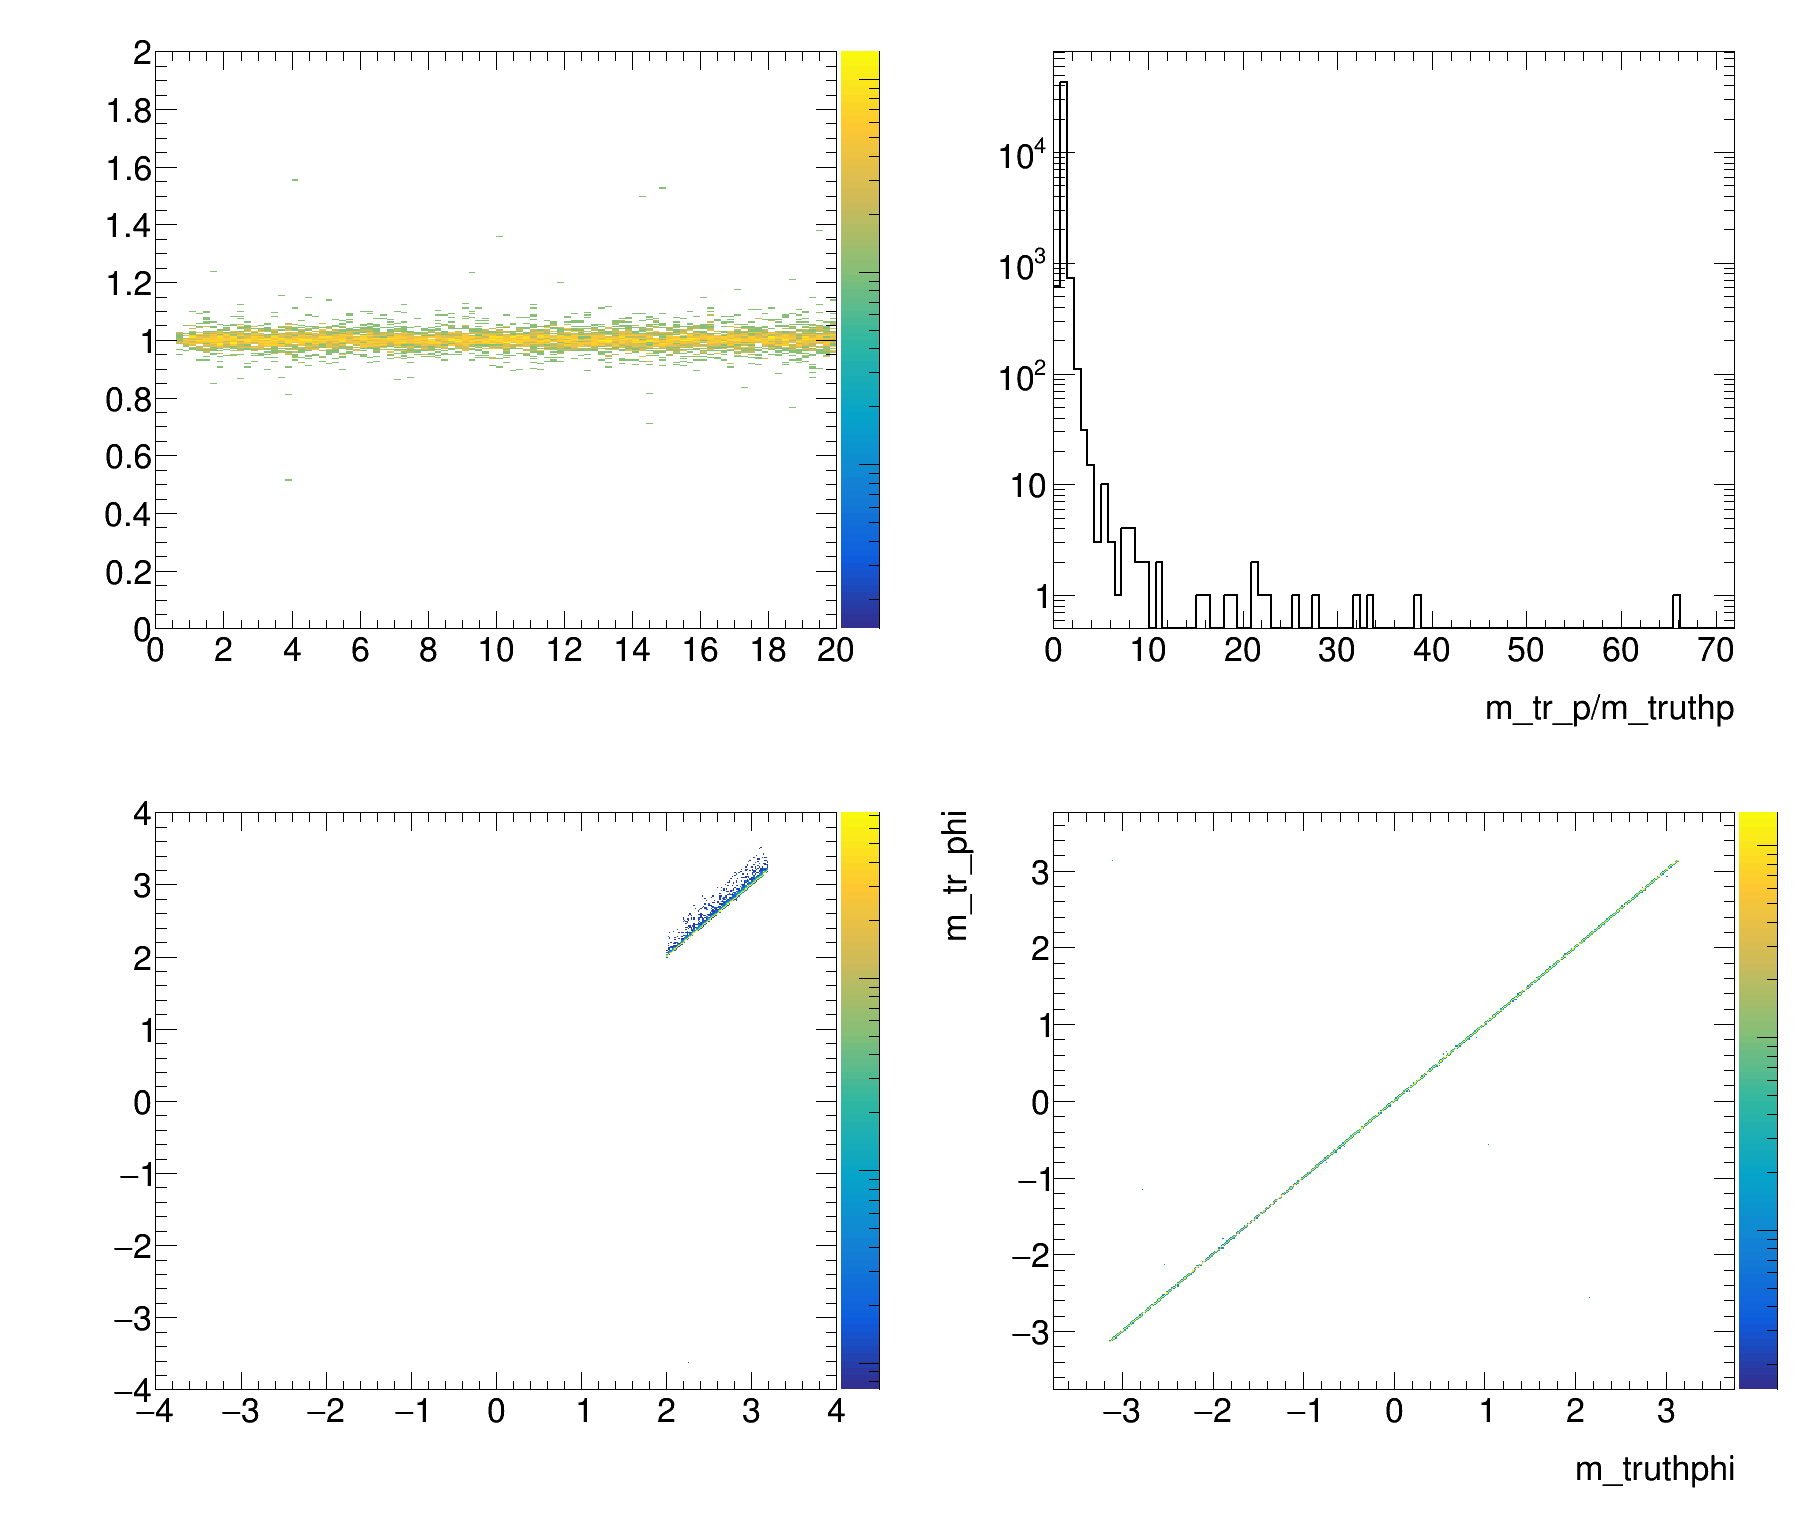

In [9]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_tr_p/m_truthp:m_truthp>>htrackreco(100,0,20,500,0,2)","m_tr_p>0","colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        T->Draw("m_tr_p/m_truthp","m_tr_p>0");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_tr_eta:m_trutheta>>heta(500,-4,4,500,-4,4)","m_tr_p>0", "colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_tr_phi:m_truthphi","m_tr_p>0", "colz");
    }
    
    
    
    c1->Draw();
}

## Calo stack

Check 7x7 tower sum next to track projection vs turth or reco momentum

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


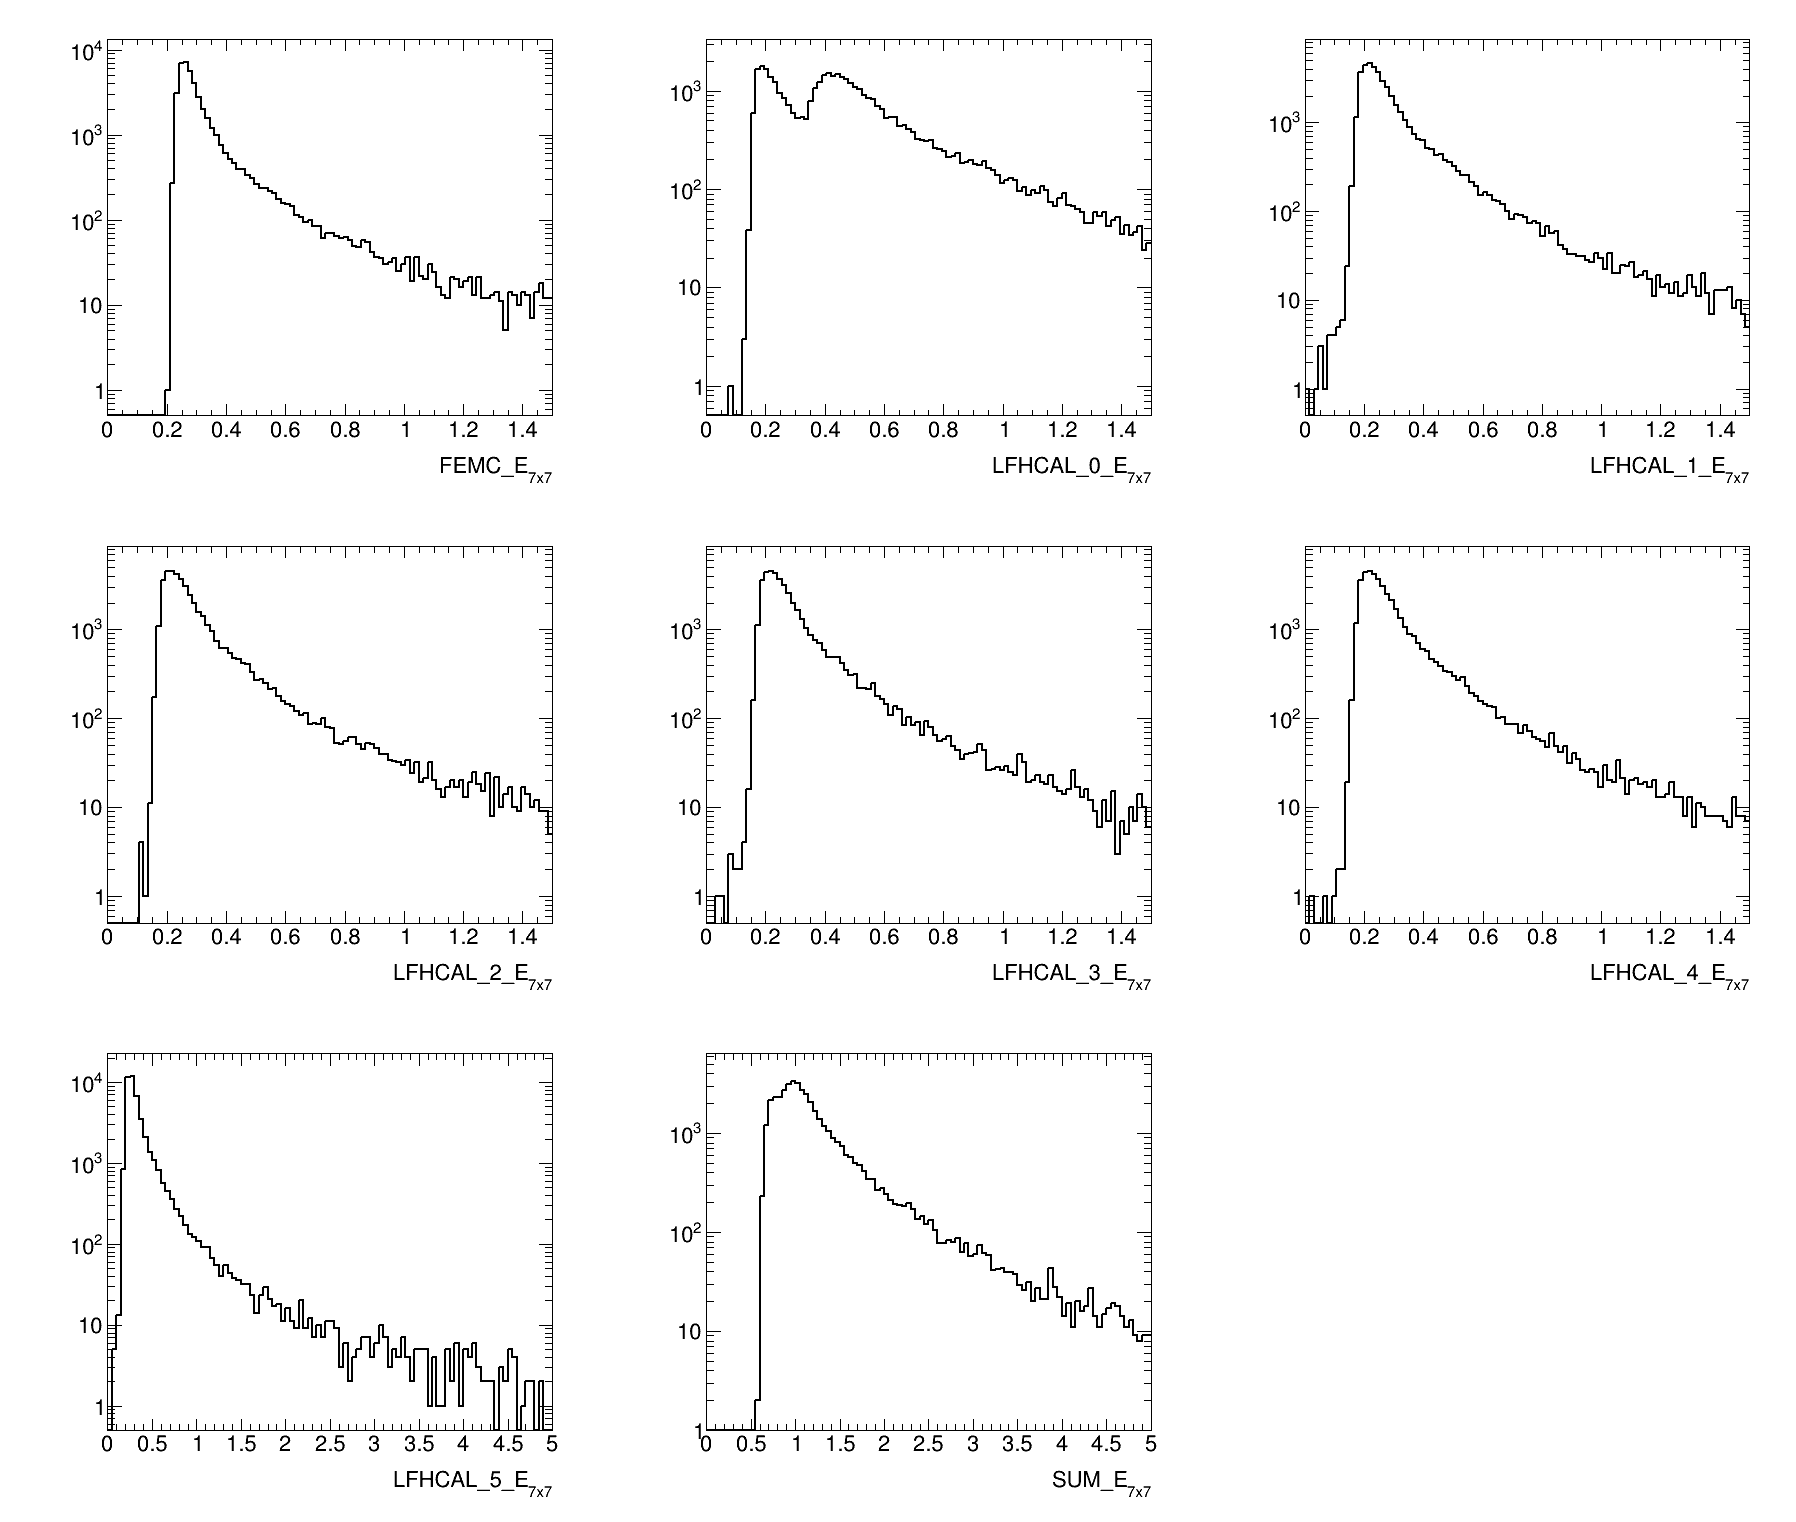

In [10]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(3, 3);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("FEMC_hE7x7pTruth",";FEMC_E_{7x7}",100,0,1.5);
        T->Draw("FEMC_Tower_E7x7>>FEMC_hE7x7pTruth","m_truthp>3");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("LFHCAL_0_hE7x7pTruth",";LFHCAL_0_E_{7x7}",100,0,1.5);
        T->Draw("LFHCAL_0_Tower_E7x7>>LFHCAL_0_hE7x7pTruth","m_truthp>3");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("LFHCAL_1_hE7x7pTruth",";LFHCAL_1_E_{7x7}",100,0,1.5);
        T->Draw("LFHCAL_1_Tower_E7x7>>LFHCAL_1_hE7x7pTruth","m_truthp>3");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("LFHCAL_2_hE7x7pTruth",";LFHCAL_2_E_{7x7}",100,0,1.5);
        T->Draw("LFHCAL_2_Tower_E7x7>>LFHCAL_2_hE7x7pTruth","m_truthp>3");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("LFHCAL_3_hE7x7pTruth",";LFHCAL_3_E_{7x7}",100,0,1.5);
        T->Draw("LFHCAL_3_Tower_E7x7>>LFHCAL_3_hE7x7pTruth","m_truthp>3");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("LFHCAL_4_hE7x7pTruth",";LFHCAL_4_E_{7x7}",100,0,1.5);
        T->Draw("LFHCAL_4_Tower_E7x7>>LFHCAL_4_hE7x7pTruth","m_truthp>3");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("LFHCAL_5_hE7x7pTruth",";LFHCAL_5_E_{7x7}",100,0,5);
        T->Draw("LFHCAL_5_Tower_E7x7>>LFHCAL_5_hE7x7pTruth","m_truthp>3");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("SUM_hE7x7pTruth",";SUM_E_{7x7}",100,0,5);
        T->Draw("FEMC_Tower_E7x7 + LFHCAL_0_Tower_E7x7 + LFHCAL_5_Tower_E7x7>>SUM_hE7x7pTruth","m_truthp>3");
    }
    
    
    
    c1->Draw();
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


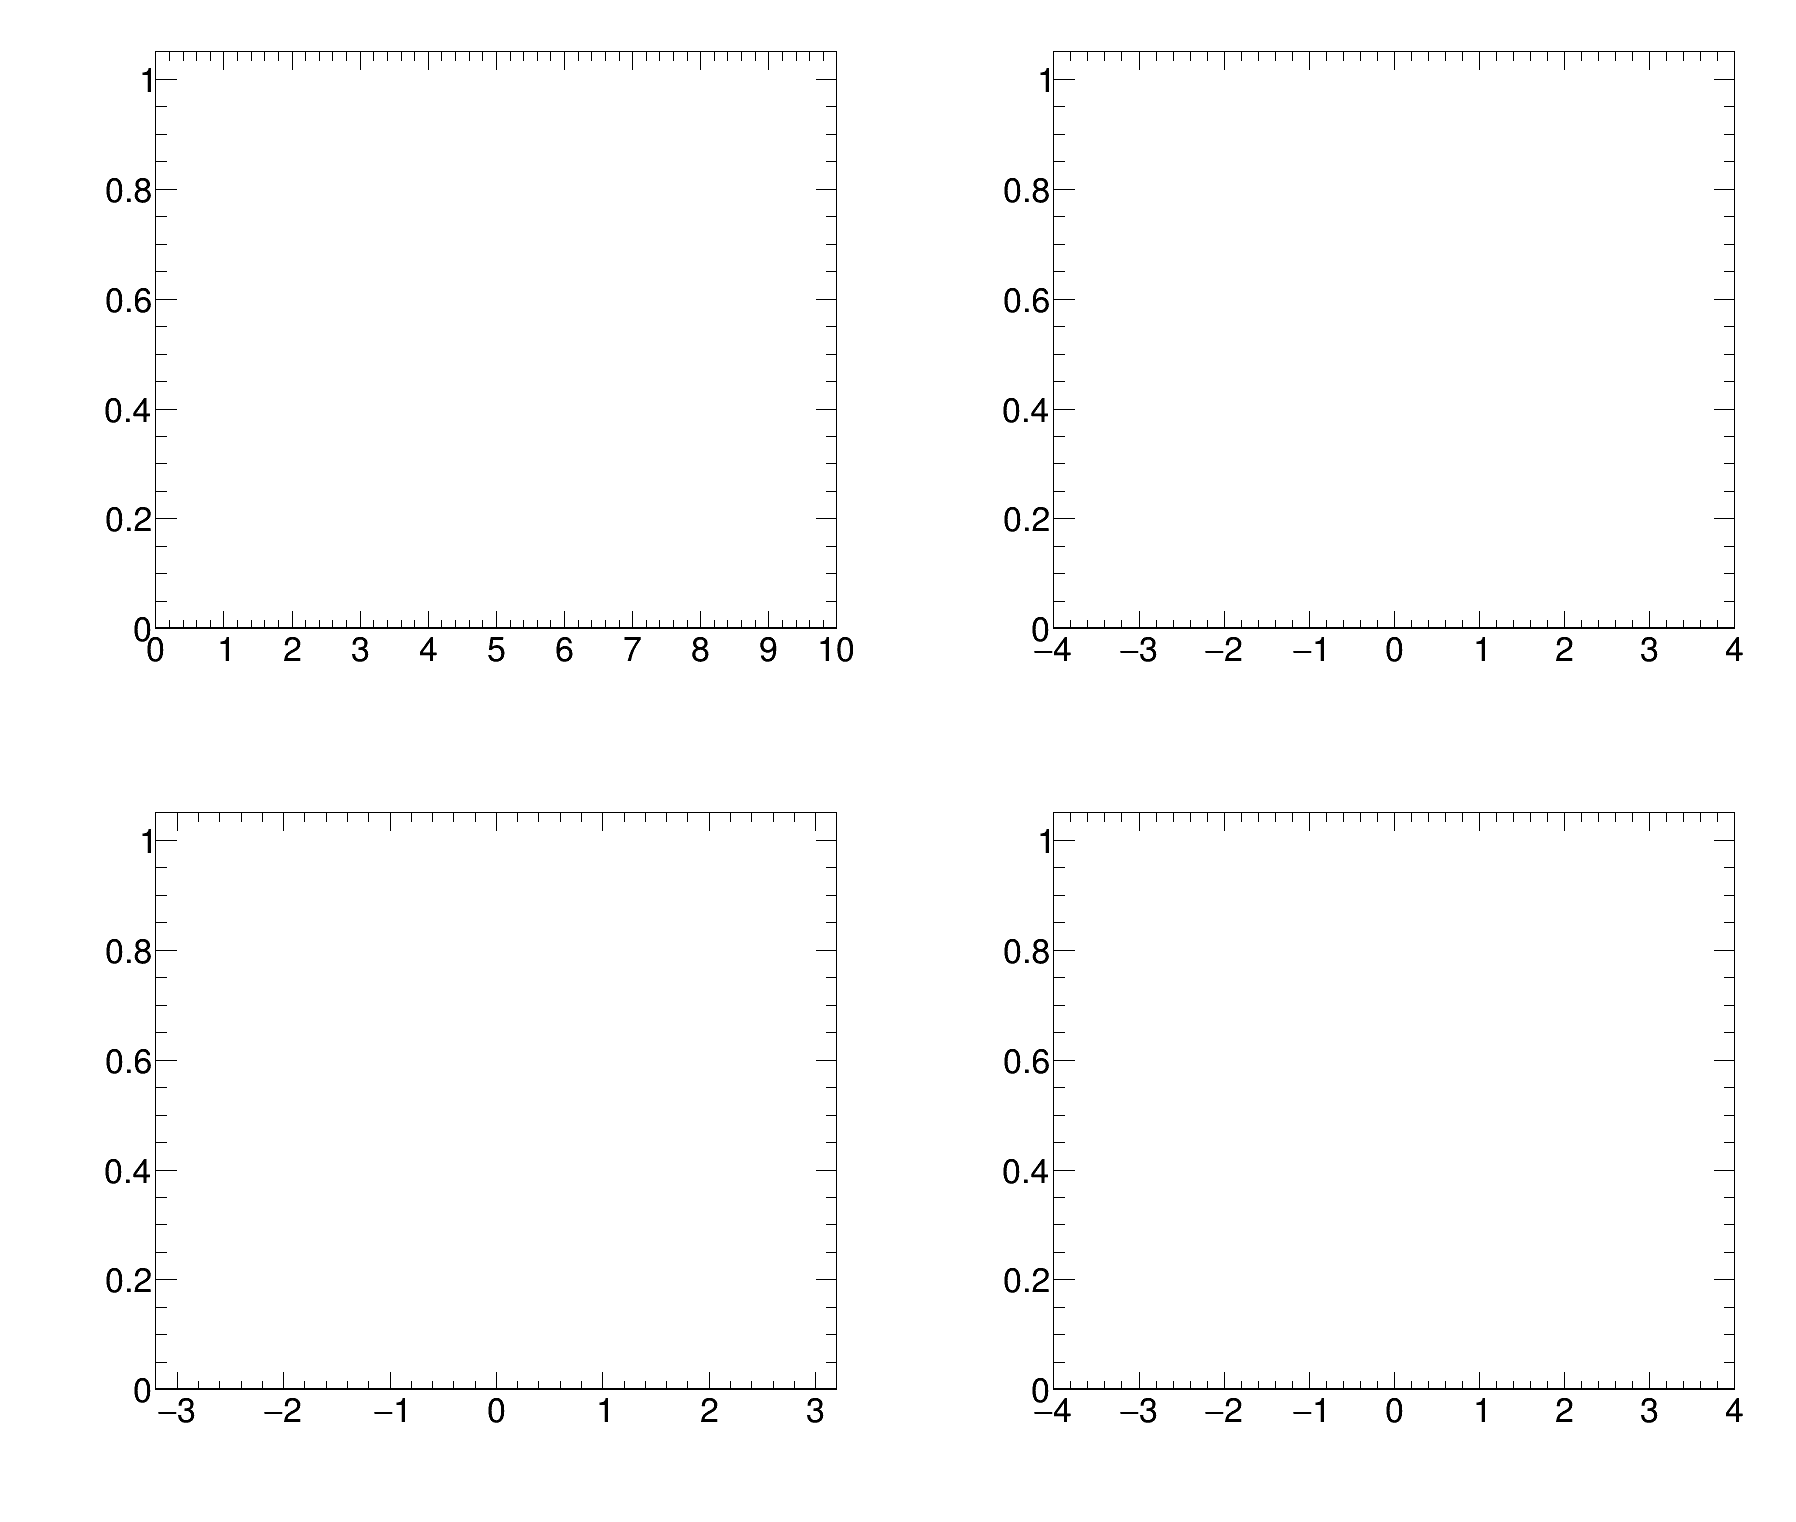

In [11]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_truthp>>hmissingp(500,0,10)","FEMC_Tower_E7x7 + LFHCAL_0_Tower_E7x7 + LFHCAL_5_Tower_E7x7<0.1", "colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_trutheta>>hmissingeta(500,-4,4)","FEMC_Tower_E7x7 + LFHCAL_0_Tower_E7x7 + LFHCAL_5_Tower_E7x7<0.1", "colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_truthphi>>hmissingphi(500,-3.2,3.2)","FEMC_Tower_E7x7 + LFHCAL_0_Tower_E7x7 + LFHCAL_5_Tower_E7x7<0.1", "colz");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        
        T->Draw("m_trutheta>>hmissingeta_emcal(500,-4,4)","FEMC_Tower_E7x7 <0.05", "colz");
    }
    
    
    c1->Draw();
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


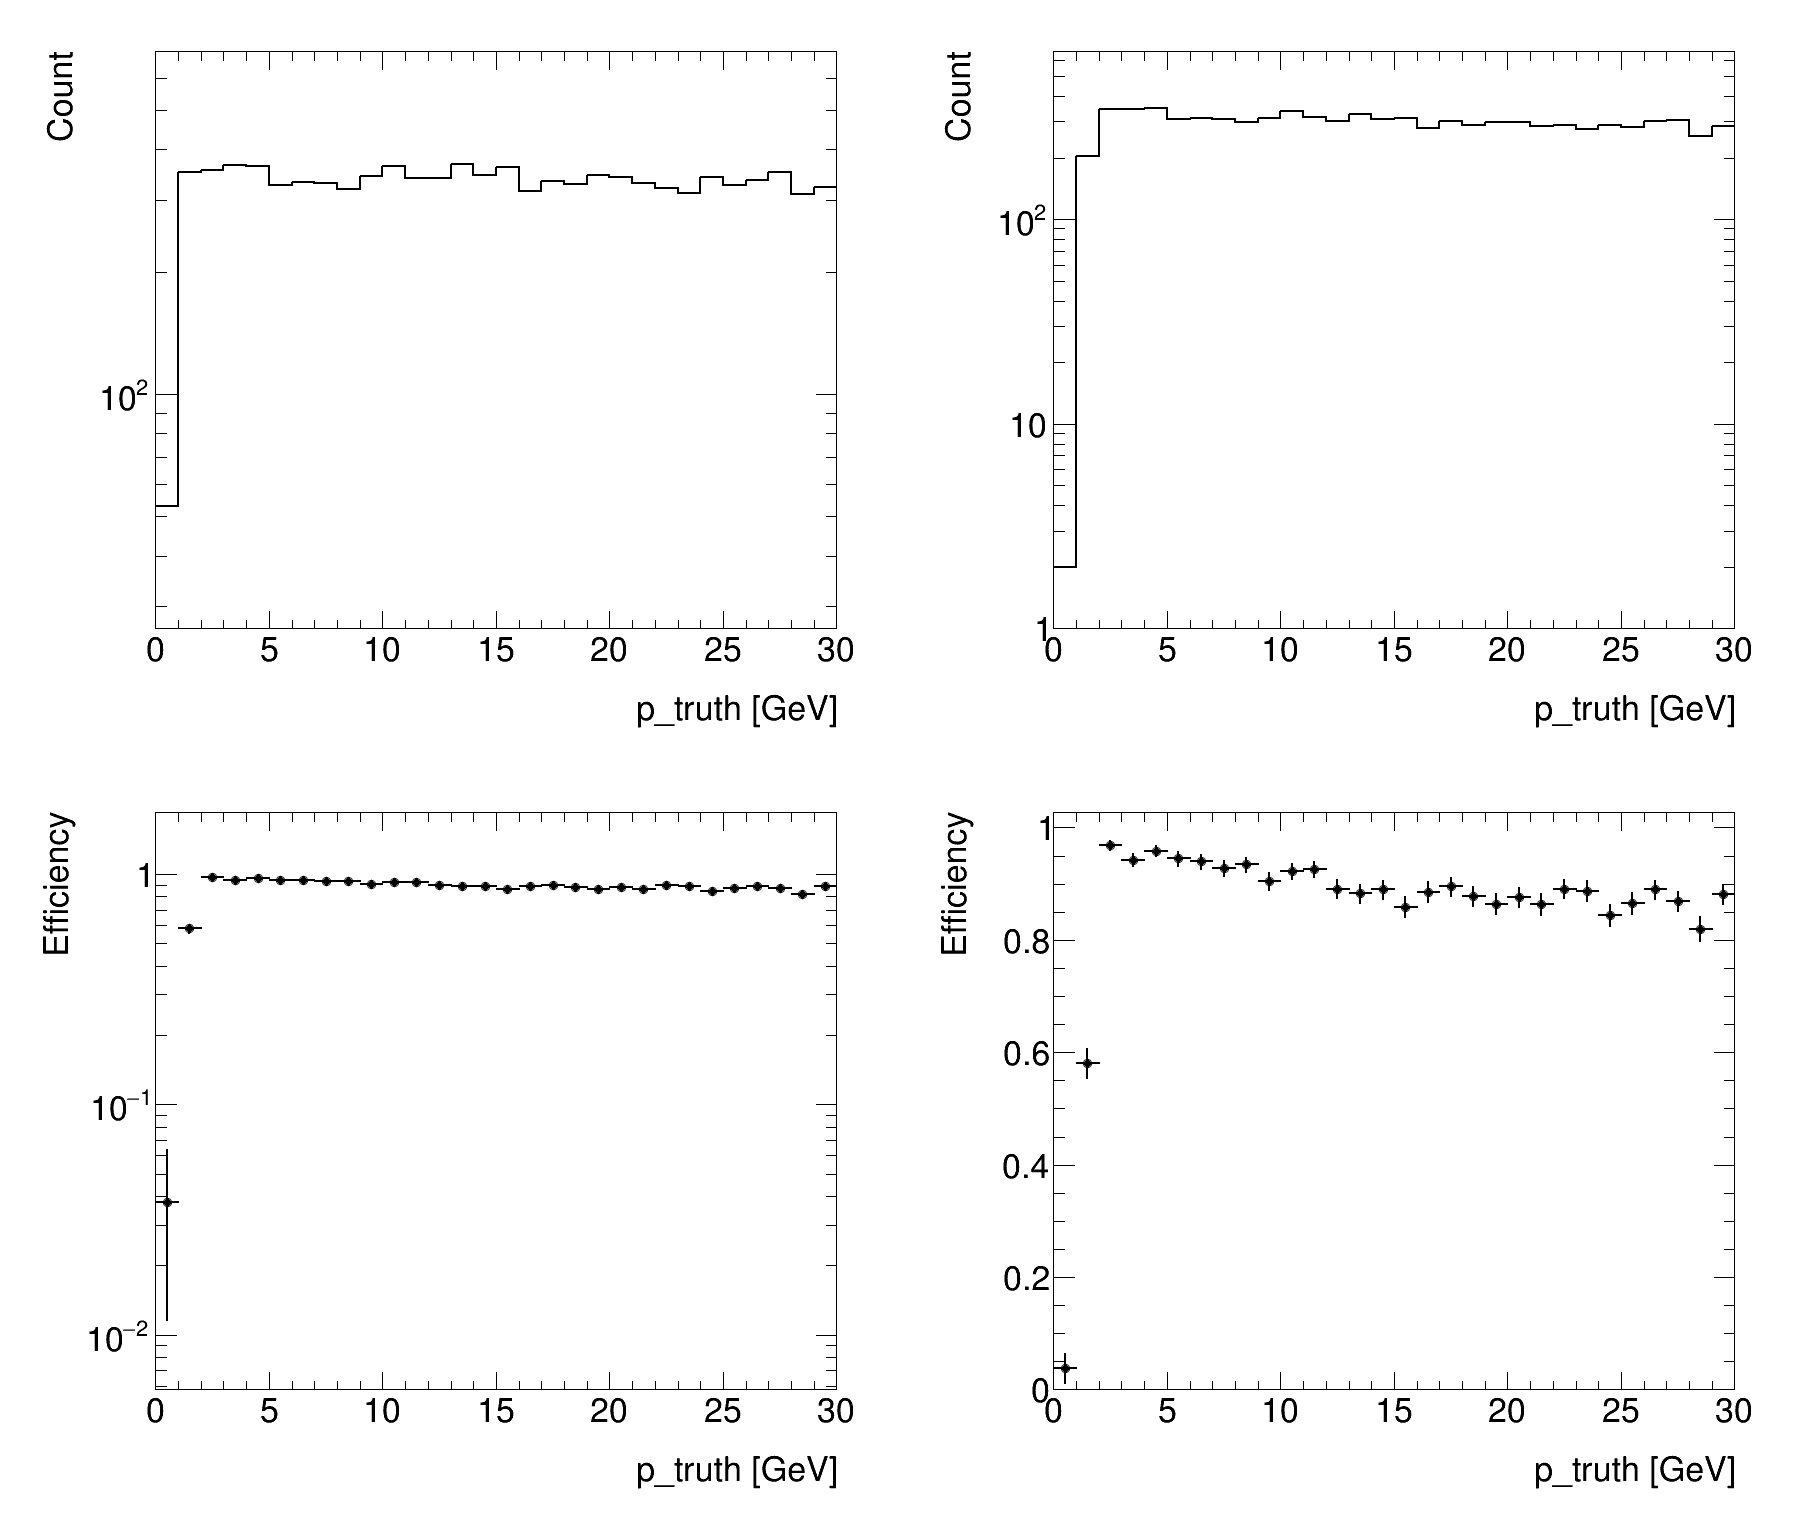

In [12]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(2,2);
    int idx = 1;
    TPad *p;

        TH1 * h_pspectrum = new TH1D("h_pspectrum",";p_truth [GeV];Count",30,0,30);
        TH1 * h_pspectrum_cut = new TH1D("h_pspectrum_cut",";p_truth [GeV];Count",30,0,30);
        TH1 * h_pspectrum_ratio = new TH1D("h_pspectrum_ratio",";p_truth [GeV];Efficiency",30,0,30);
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        T->Draw("m_truthp>>h_pspectrum","", "");
      }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        T->Draw("m_truthp>>h_pspectrum_cut",
                "FEMC_Tower_E7x7 <0.5 && LFHCAL_0_Tower_E7x7 < 1 && LFHCAL_1_Tower_E7x7 < 1 && LFHCAL_2_Tower_E7x7 < 1 && LFHCAL_3_Tower_E7x7 < 1 && LFHCAL_4_Tower_E7x7 < 1 && LFHCAL_4_Tower_E7x7 > .1 && LFHCAL_5_Tower_E7x7 <1.5 && LFHCAL_5_Tower_E7x7 > 0.1", "");
      }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
 
        h_pspectrum_ratio->Divide(h_pspectrum_cut, h_pspectrum, 1, 1, "B");
        h_pspectrum_ratio->Draw();
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        
        
        h_pspectrum_ratio->Draw();
    }
    
    
    c1->Draw();
}

## FEMC

Check 7x7 tower sum next to track projection vs turth or reco momentum

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


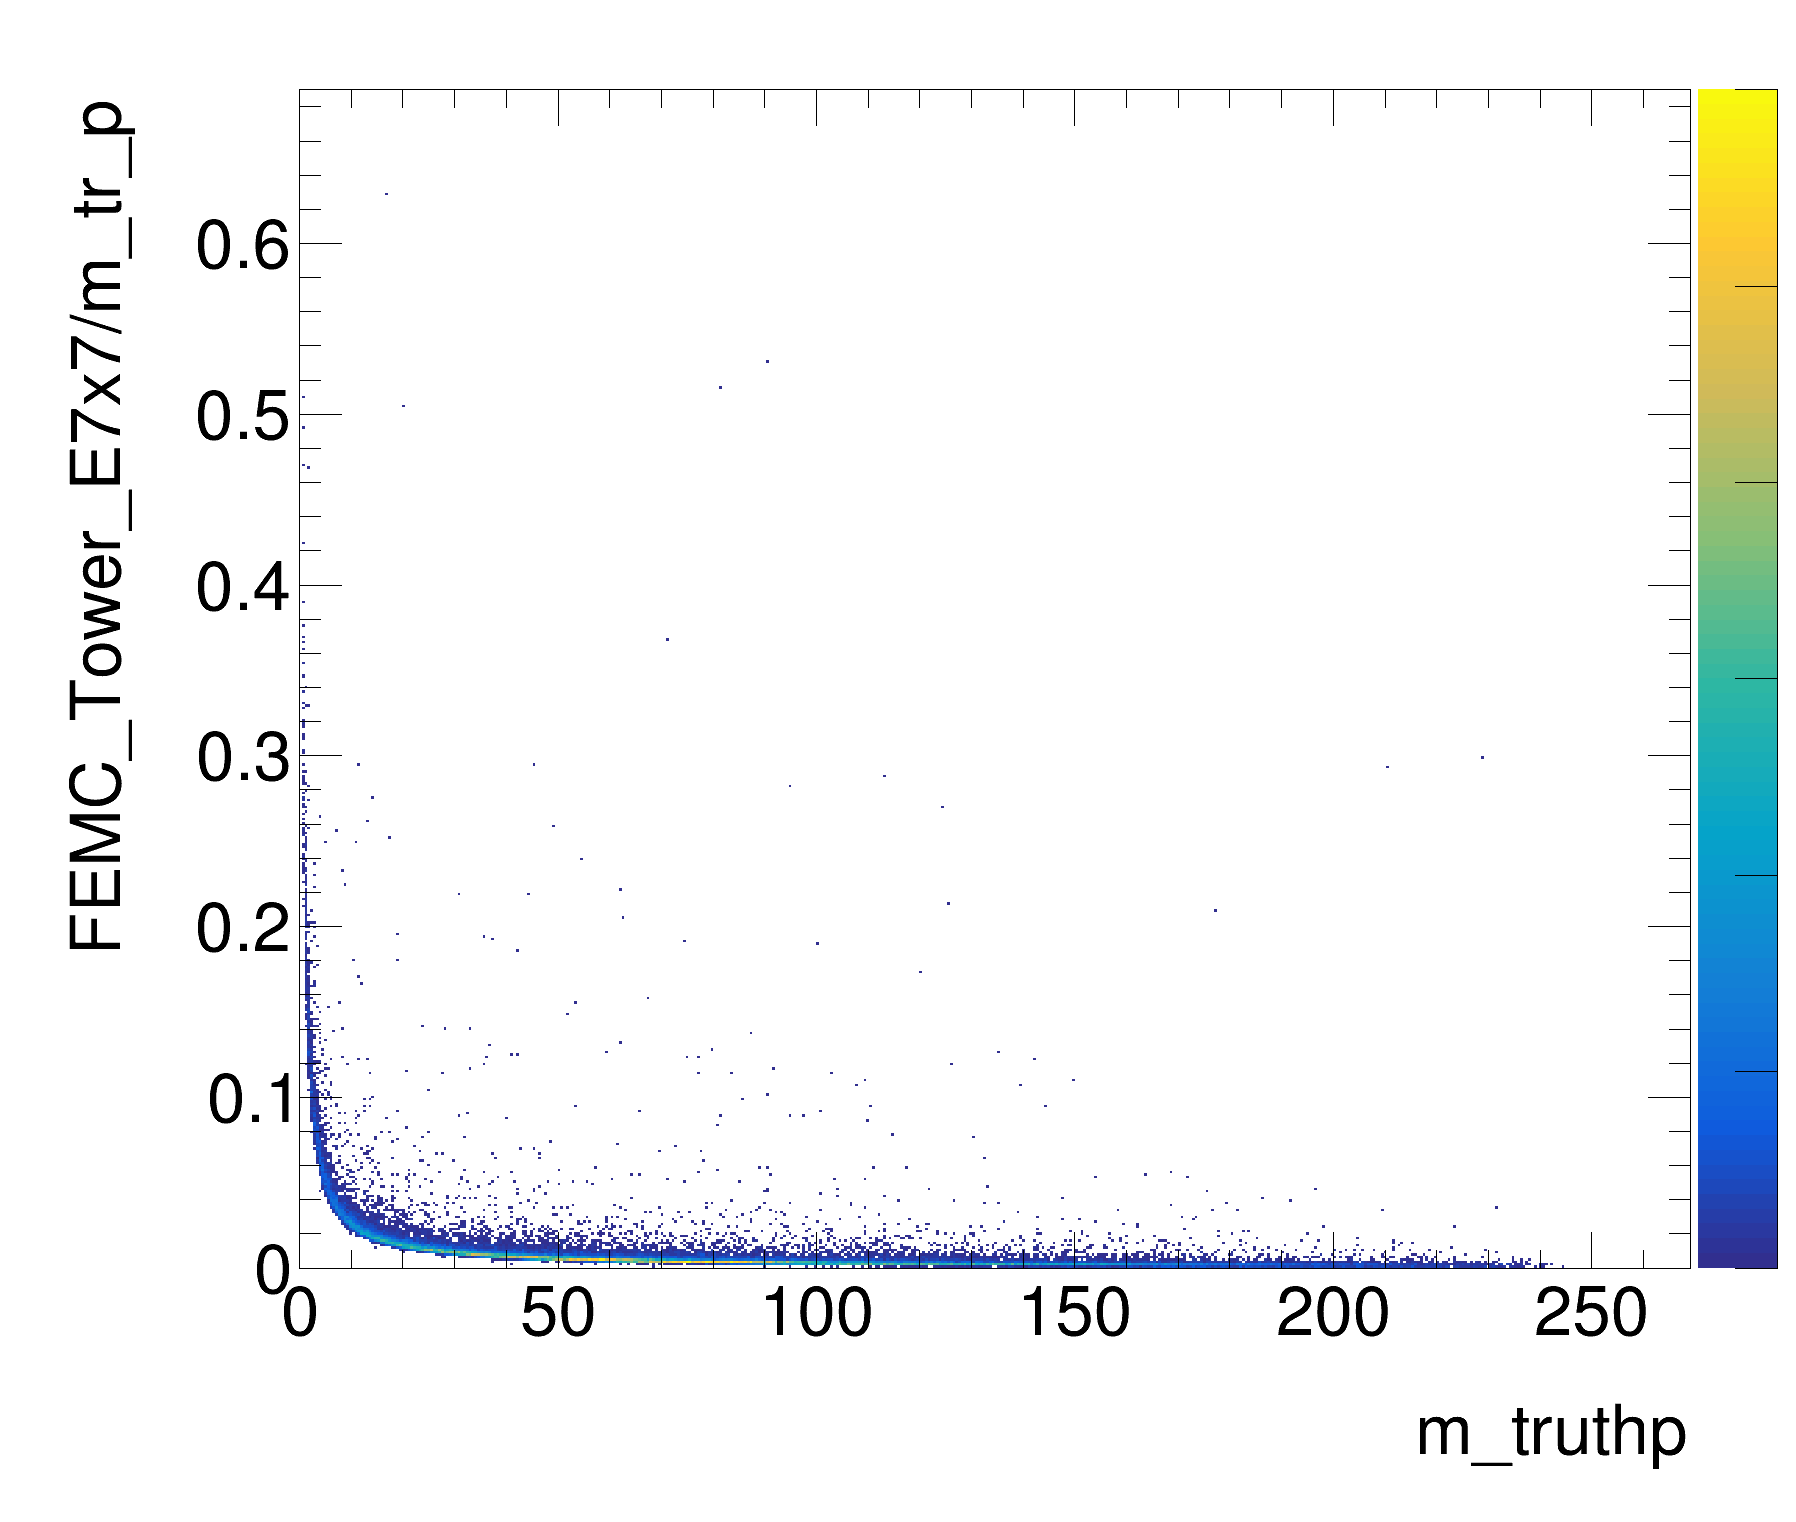

In [13]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("FEMC_Tower_E7x7/m_tr_p:m_truthp","m_tr_p>0","colz");
    }
    
    
    c1->Draw();
}

### Track based shower profile check

#### Shower shape in 7x7 tower patch grid

Check 7x7 tower patch next to the track projection with weight of the tower energy


Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


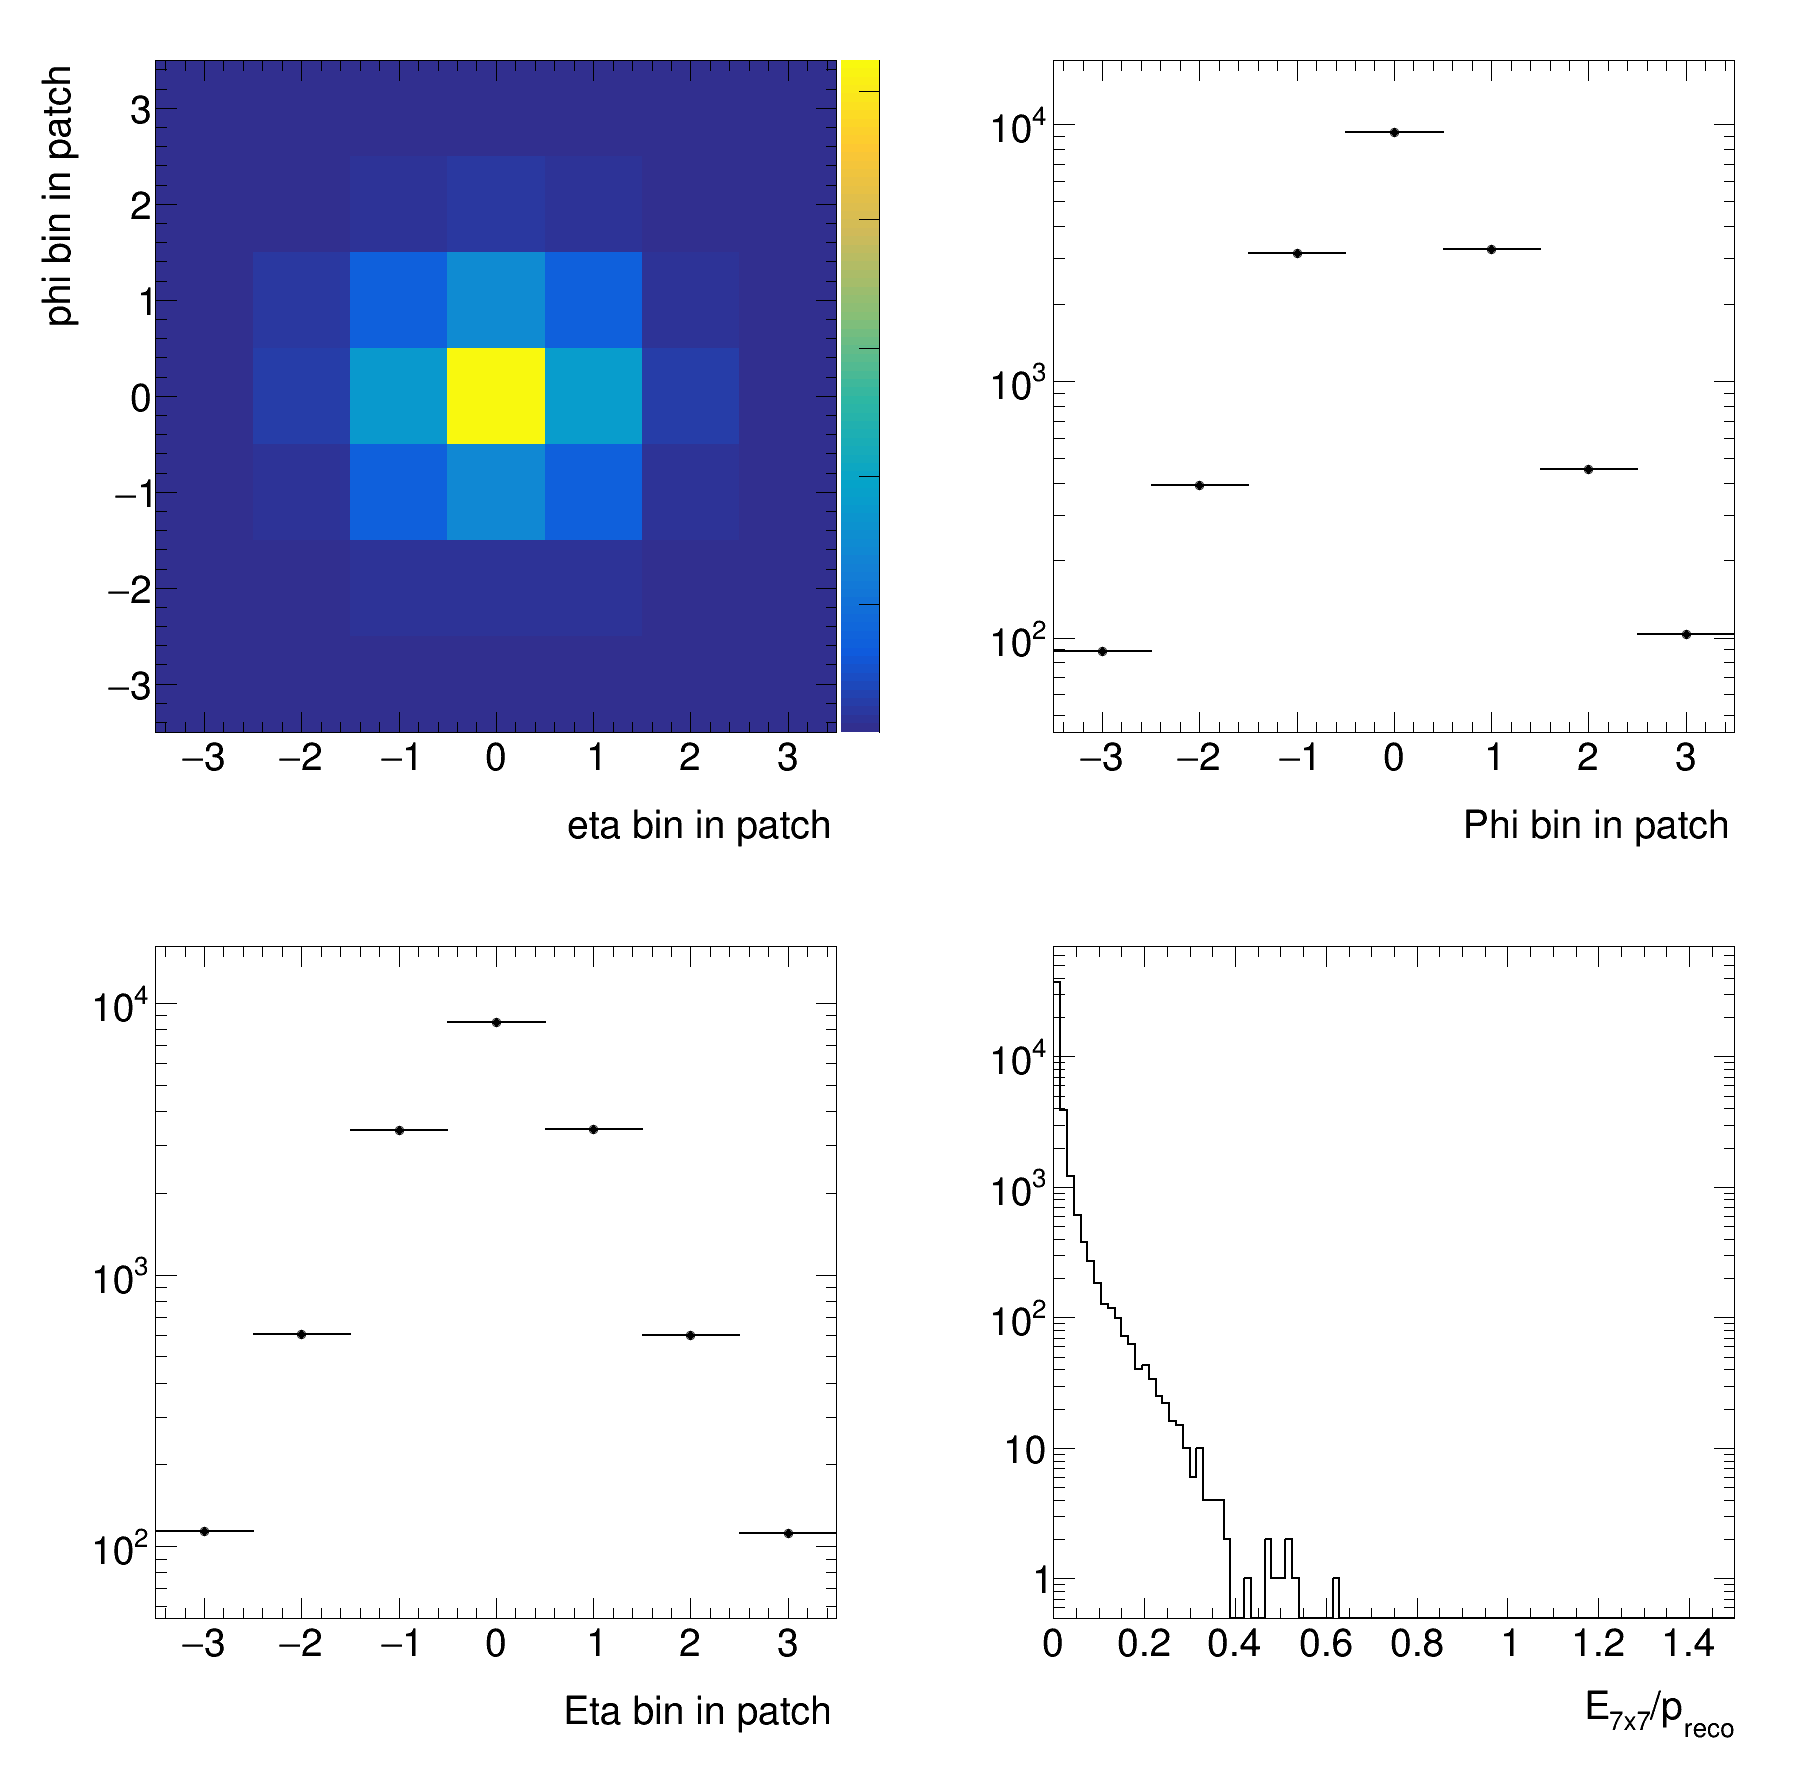

In [14]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta bin in patch;phi bin in patch",7,-3.5,3.5,7,-3.5,3.5);
        T->Draw("FEMC_Tower_iPhi_patch:FEMC_Tower_iEta_patch>>hpatch2D","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";Phi bin in patch",7,-3.5,3.5);
        T->Draw("FEMC_Tower_iPhi_patch>>hpatchPhi","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";Eta bin in patch",7,-3.5,3.5);
        T->Draw("FEMC_Tower_iEta_patch>>hpatchEta","FEMC_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",100,0,1.5);
        T->Draw("FEMC_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

#### shower shape in eta phi distance

Warning in <TFile::Append>: Replacing existing TH1: hpatch2D (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchPhi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hE7x7pTruth (Potential memory leak).


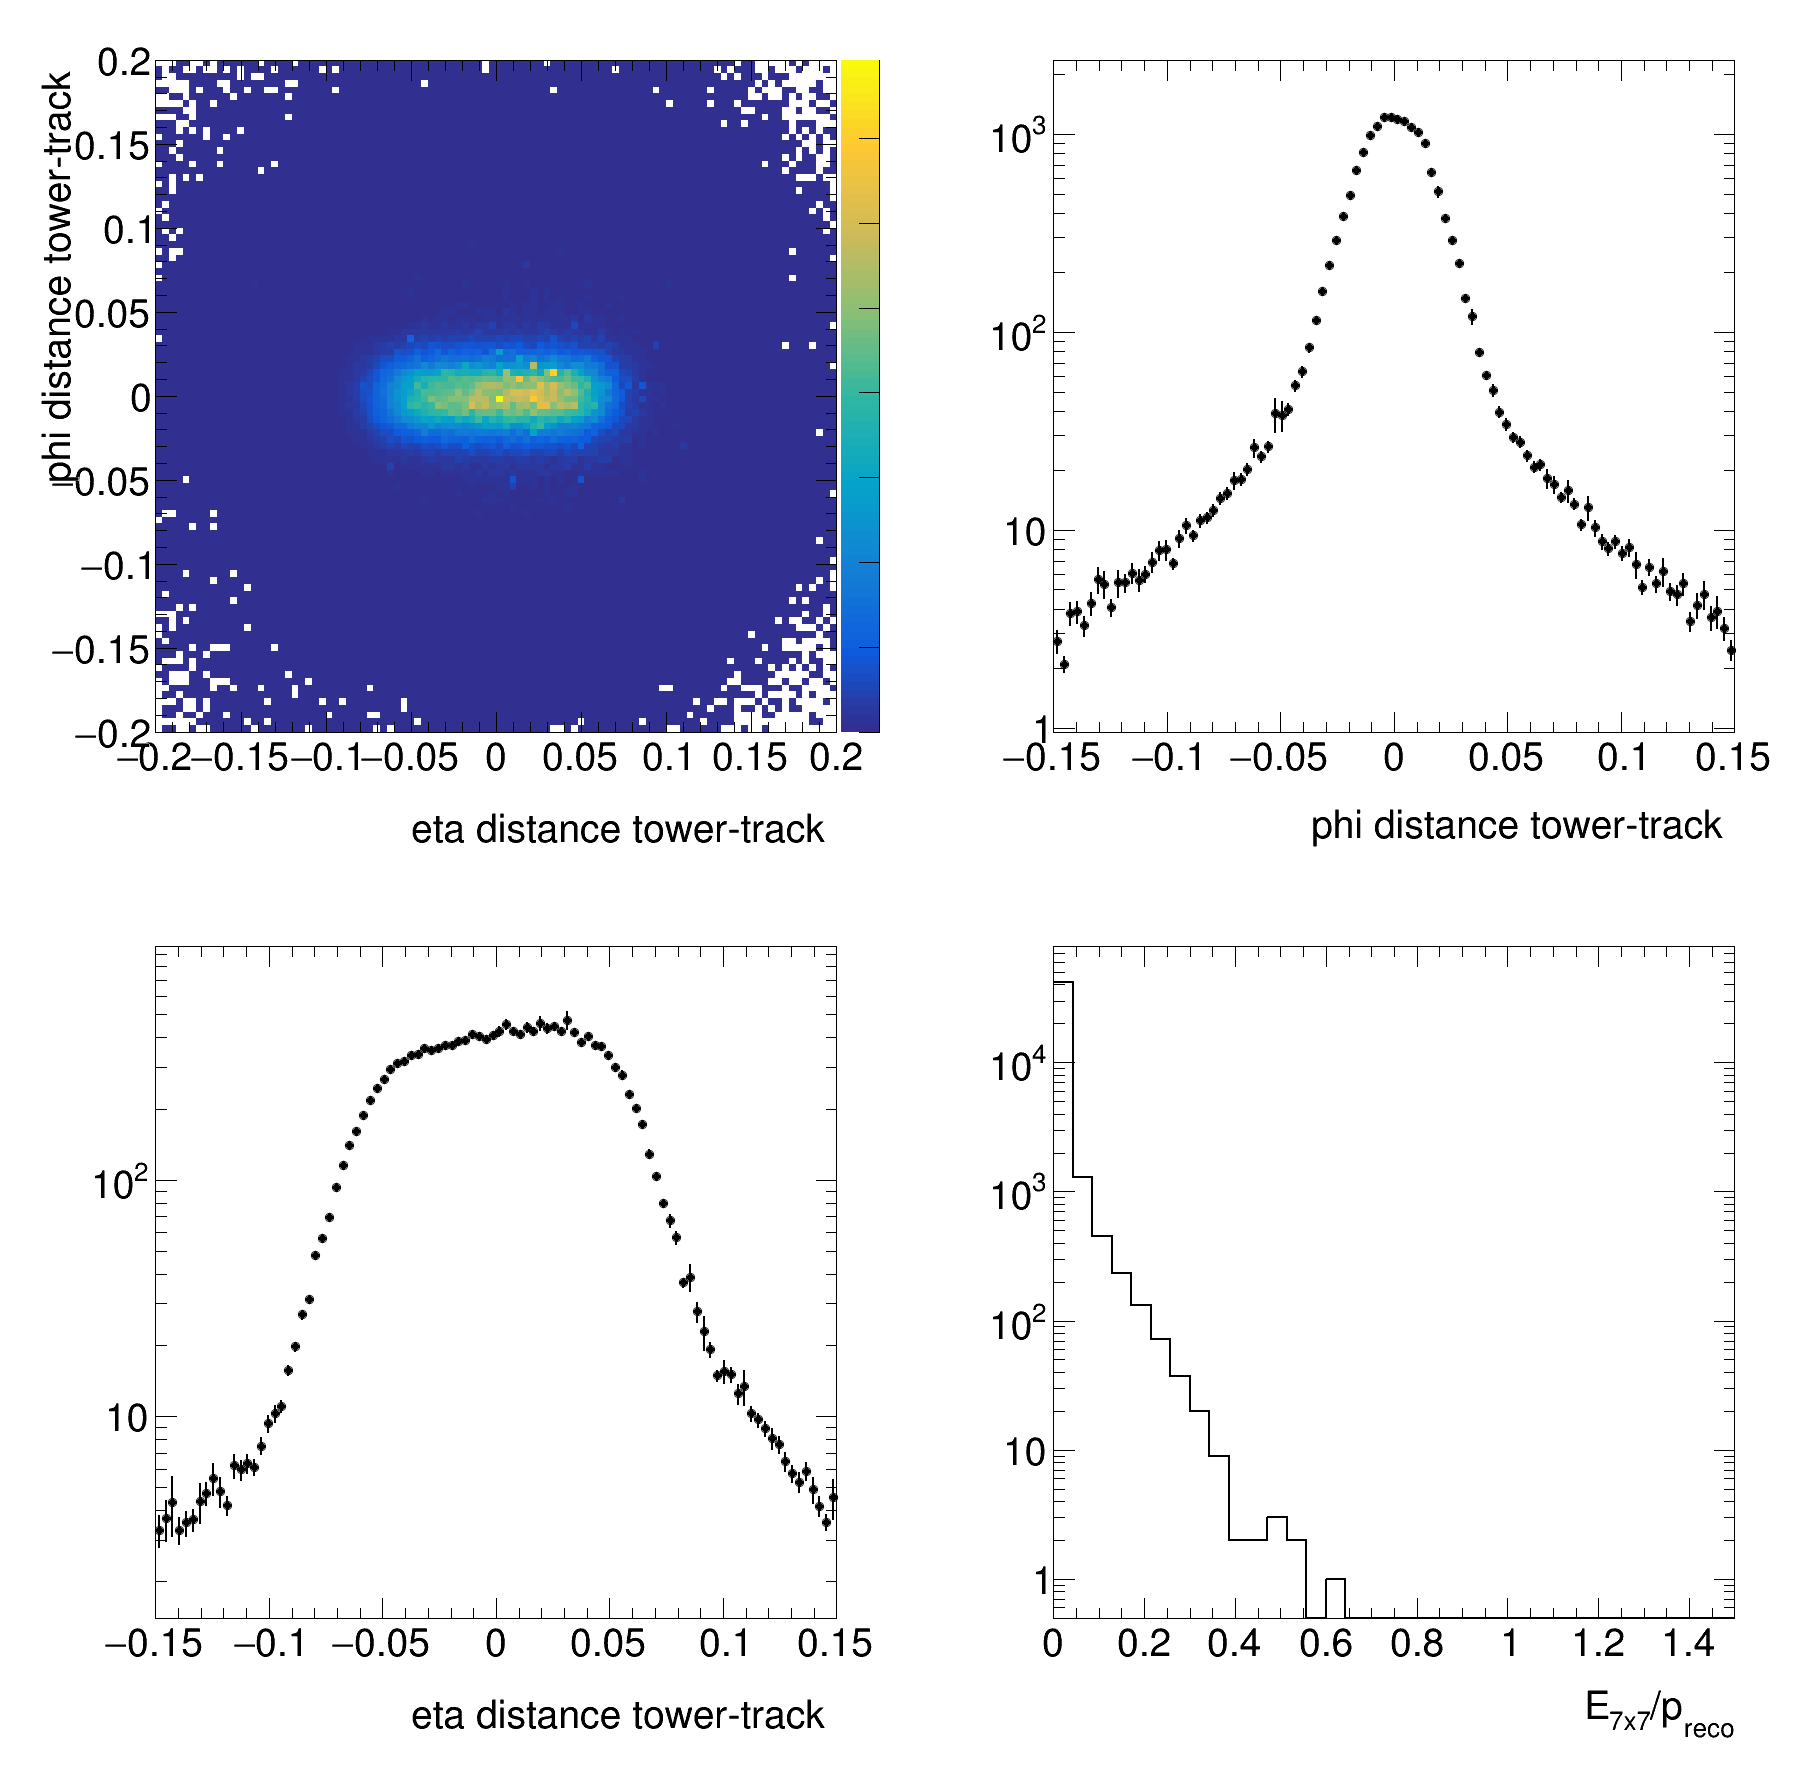

In [15]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerEtaPhiScan";
    auto c1 = new TCanvas(TString("TowerEtaPhiScan") ,
                        TString("TowerEtaPhiScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta distance tower-track;phi distance tower-track",100,-.2,.2, 100,-.2,.2);
        T->Draw("FEMC_Tower_dPhi:FEMC_Tower_dEta>>hpatch2D","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";phi distance tower-track",100,-.15,.15);
        T->Draw("FEMC_Tower_dPhi>>hpatchPhi","FEMC_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";eta distance tower-track",100,-.15,.15);
        T->Draw("FEMC_Tower_dEta>>hpatchEta","FEMC_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",35,0,1.5);
        T->Draw("FEMC_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

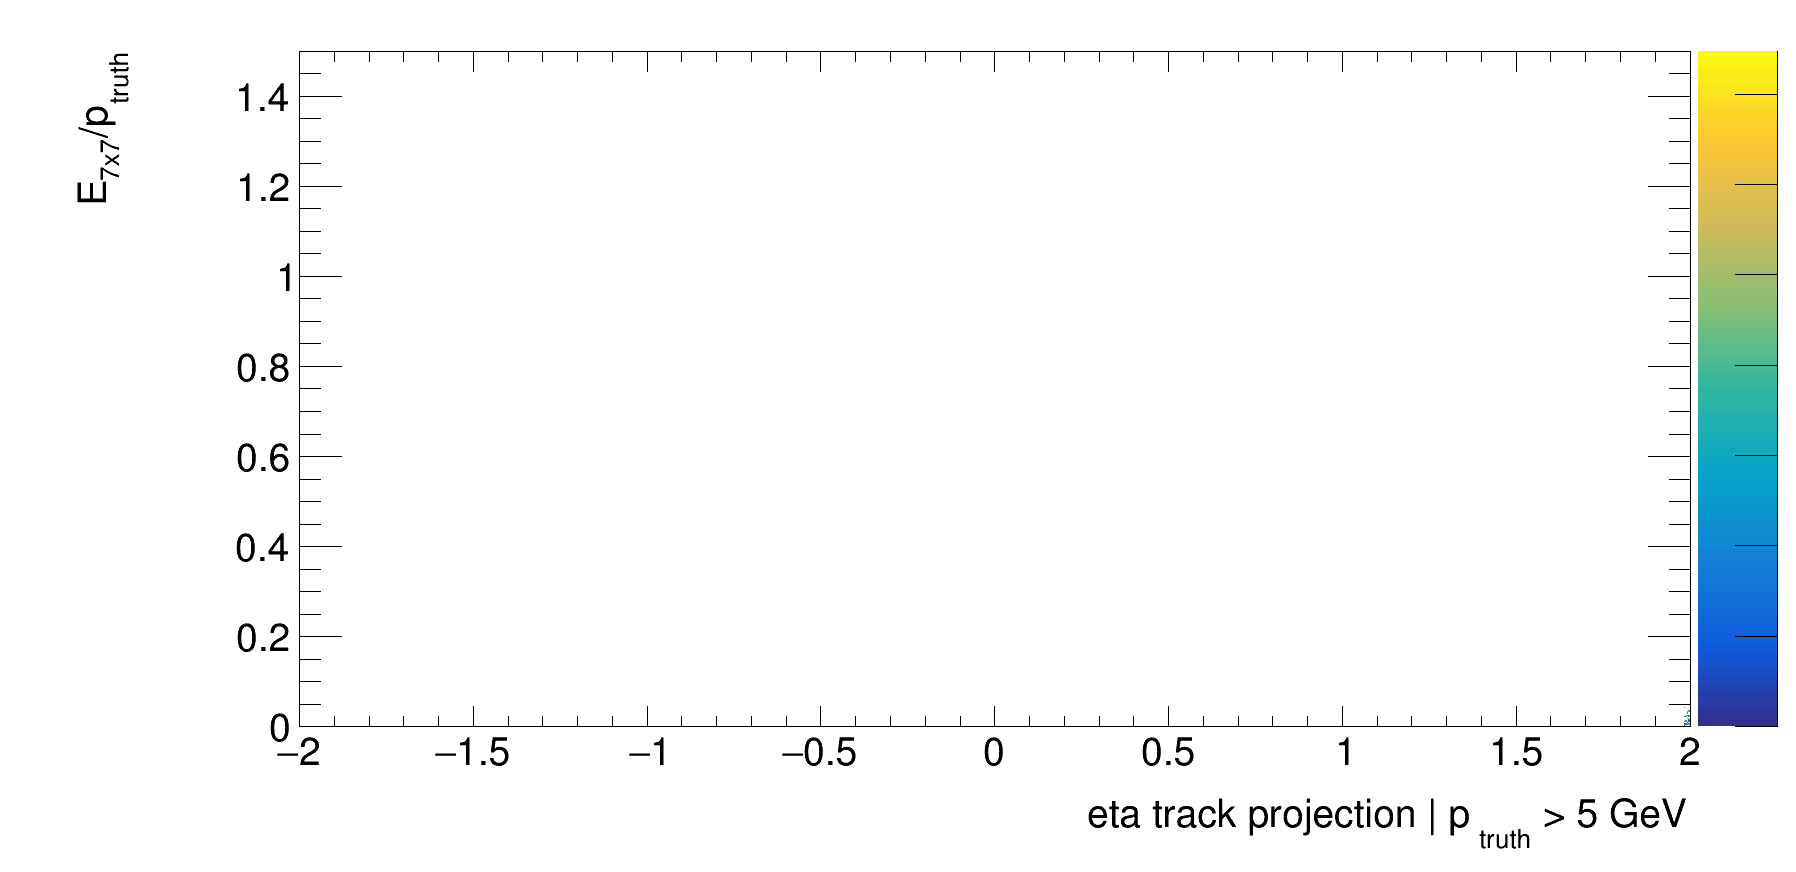

In [16]:
%%cpp

{

    
    const char *hist_name_prefix = "ShowerScan";
    auto c1 = new TCanvas(TString("ShowerScan") ,
                        TString("TowerScan"),
                        1800, 900);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hEpresponse",";eta track projection | p_{truth} > 5 GeV;E_{7x7}/p_{truth}", 1000,-2,2, 1000,0,1.5);
        T->Draw("FEMC_Tower_E7x7/m_tr_p:TMath::ATanH(FEMC_proj_z/sqrt(FEMC_proj_x**2 + FEMC_proj_y**2 + FEMC_proj_z**2))>>hEpresponse","(FEMC_Tower_E7x7/m_truthp) * (m_truthp>5)","colz");
        
    }
    c1->Draw();
}

## LFHCAL_0

Check 7x7 tower sum next to track projection vs turth or reco momentum

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


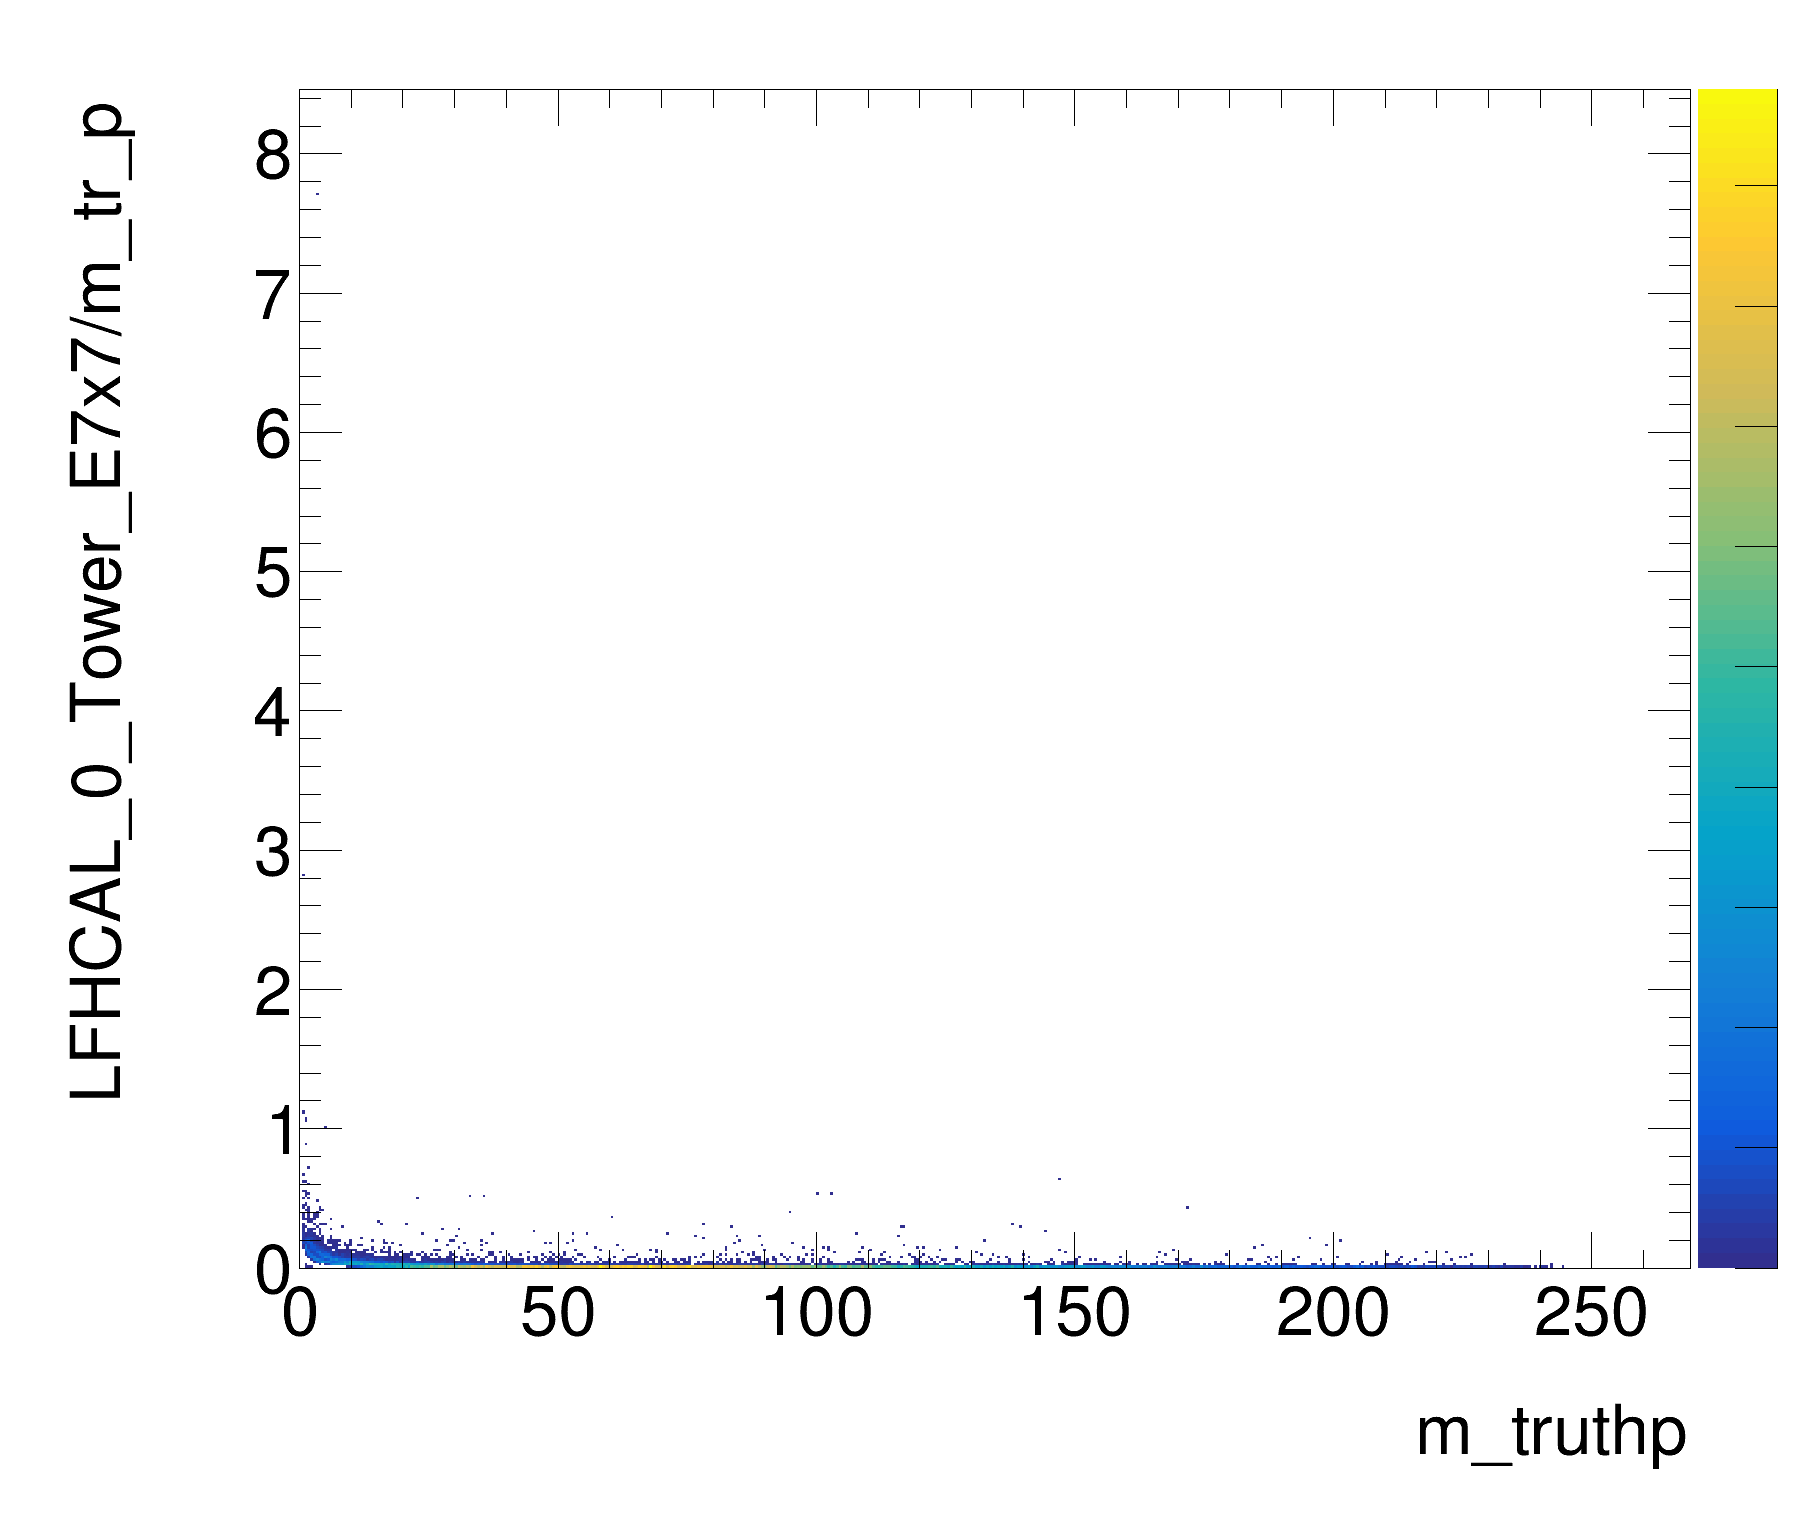

In [17]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("LFHCAL_0_Tower_E7x7/m_tr_p:m_truthp","m_tr_p>0","colz");
    }
    
    
    c1->Draw();
}

### Track based shower profile check

#### Shower shape in 7x7 tower patch grid

Check 7x7 tower patch next to the track projection with weight of the tower energy


Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan
Warning in <TFile::Append>: Replacing existing TH1: hpatch2D (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchPhi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hE7x7pTruth (Potential memory leak).


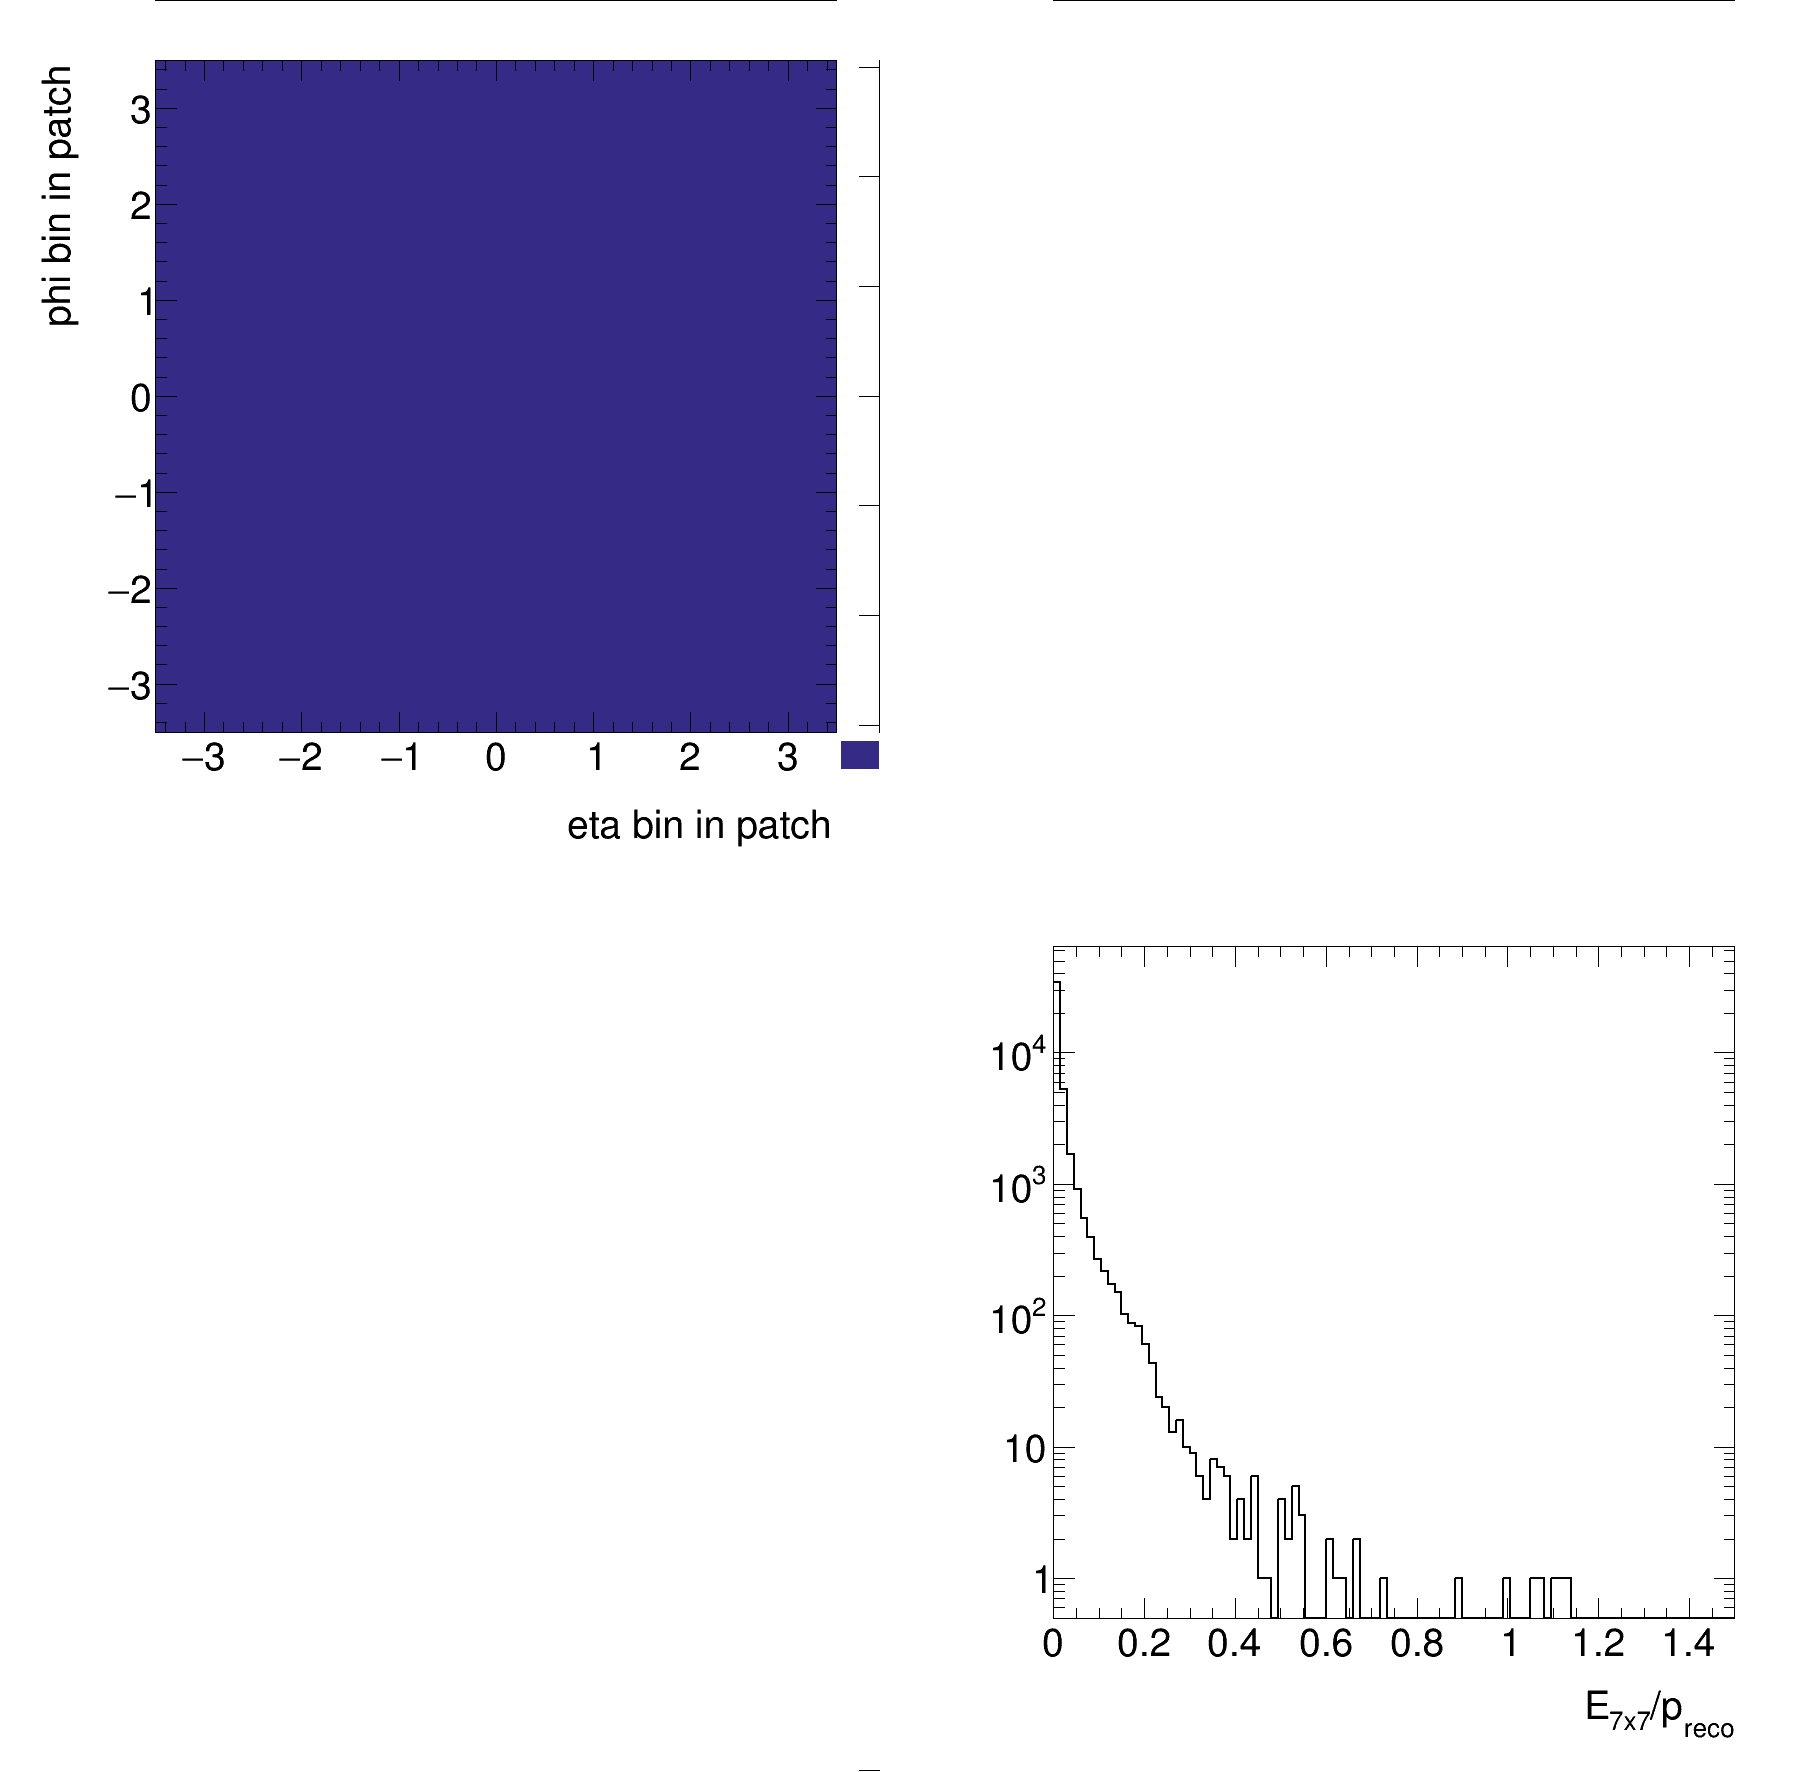

In [18]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta bin in patch;phi bin in patch",7,-3.5,3.5,7,-3.5,3.5);
        T->Draw("LFHCAL_0_Tower_iPhi_patch:LFHCAL_0_Tower_iEta_patch>>hpatch2D","LFHCAL_0_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";Phi bin in patch",7,-3.5,3.5);
        T->Draw("LFHCAL_0_Tower_iPhi_patch>>hpatchPhi","LFHCAL_0_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";Eta bin in patch",7,-3.5,3.5);
        T->Draw("LFHCAL_0_Tower_iEta_patch>>hpatchEta","LFHCAL_0_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",100,0,1.5);
        T->Draw("LFHCAL_0_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

#### shower shape in eta phi distance

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerEtaPhiScan
Warning in <TFile::Append>: Replacing existing TH1: hpatch2D (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchPhi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hE7x7pTruth (Potential memory leak).


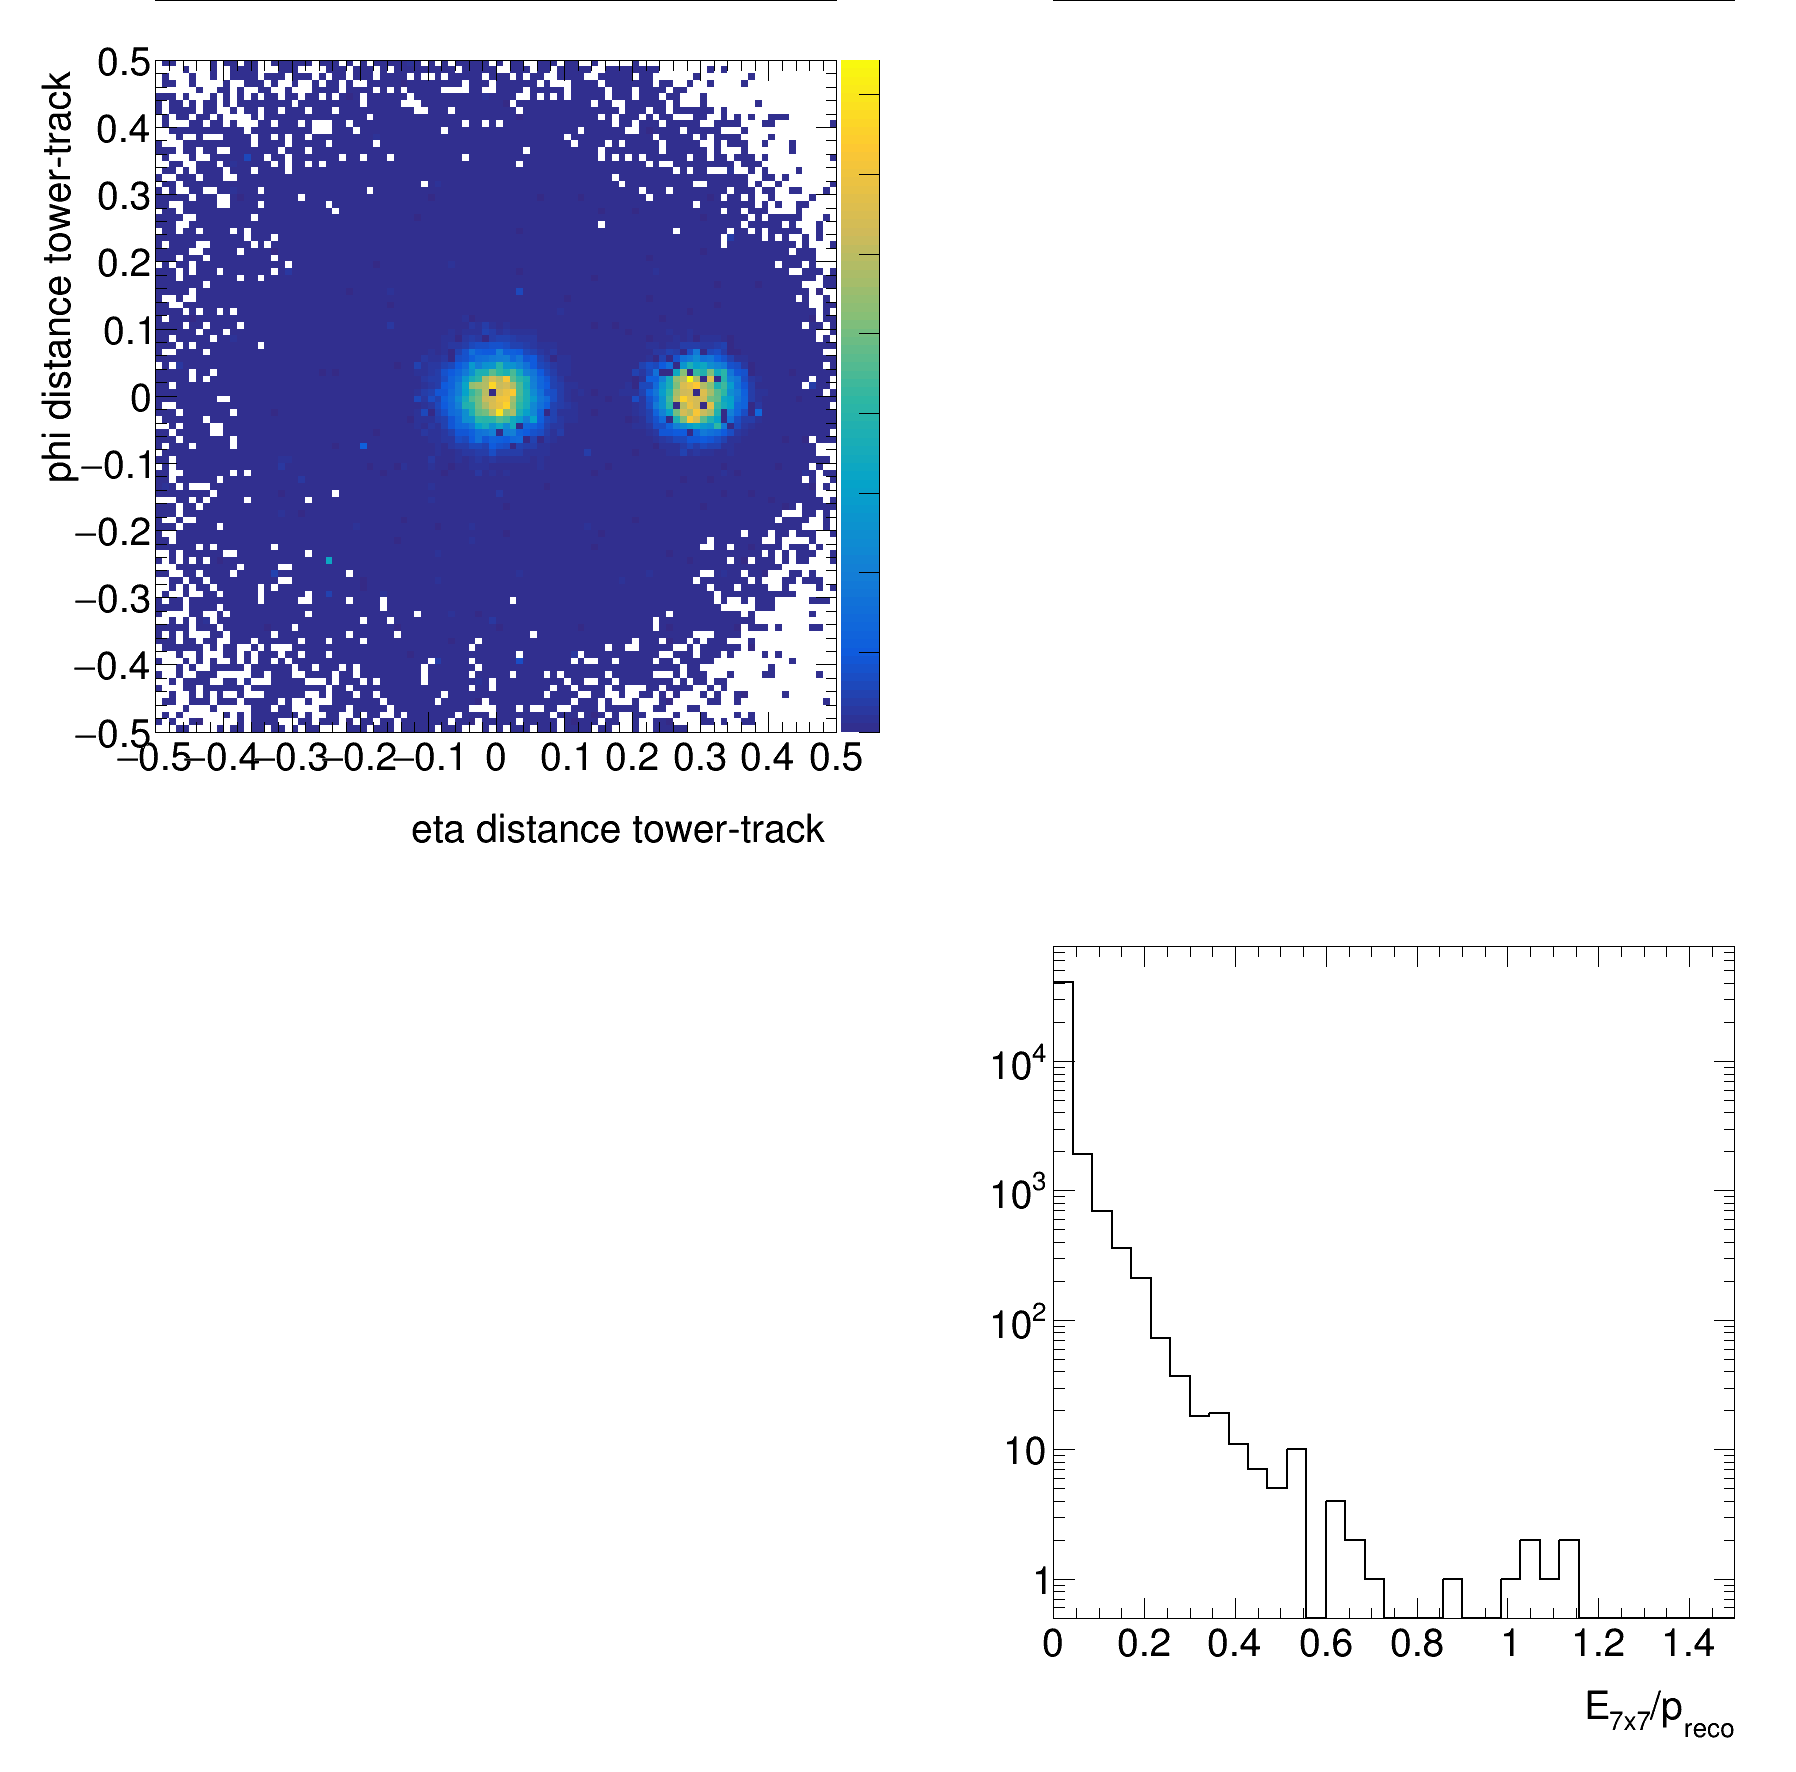

In [19]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerEtaPhiScan";
    auto c1 = new TCanvas(TString("TowerEtaPhiScan") ,
                        TString("TowerEtaPhiScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta distance tower-track;phi distance tower-track",100,-.5,.5, 100,-.5,.5);
        T->Draw("LFHCAL_0_Tower_dPhi:LFHCAL_0_Tower_dEta>>hpatch2D","LFHCAL_0_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";phi distance tower-track",100,-.5,.5);
        T->Draw("LFHCAL_0_Tower_dPhi>>hpatchPhi","LFHCAL_0_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";eta distance tower-track",100,-.5,.5);
        T->Draw("LFHCAL_0_Tower_dEta>>hpatchEta","LFHCAL_0_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",35,0,1.5);
        T->Draw("LFHCAL_0_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ShowerScan
Warning in <TFile::Append>: Replacing existing TH1: hEpresponse (Potential memory leak).


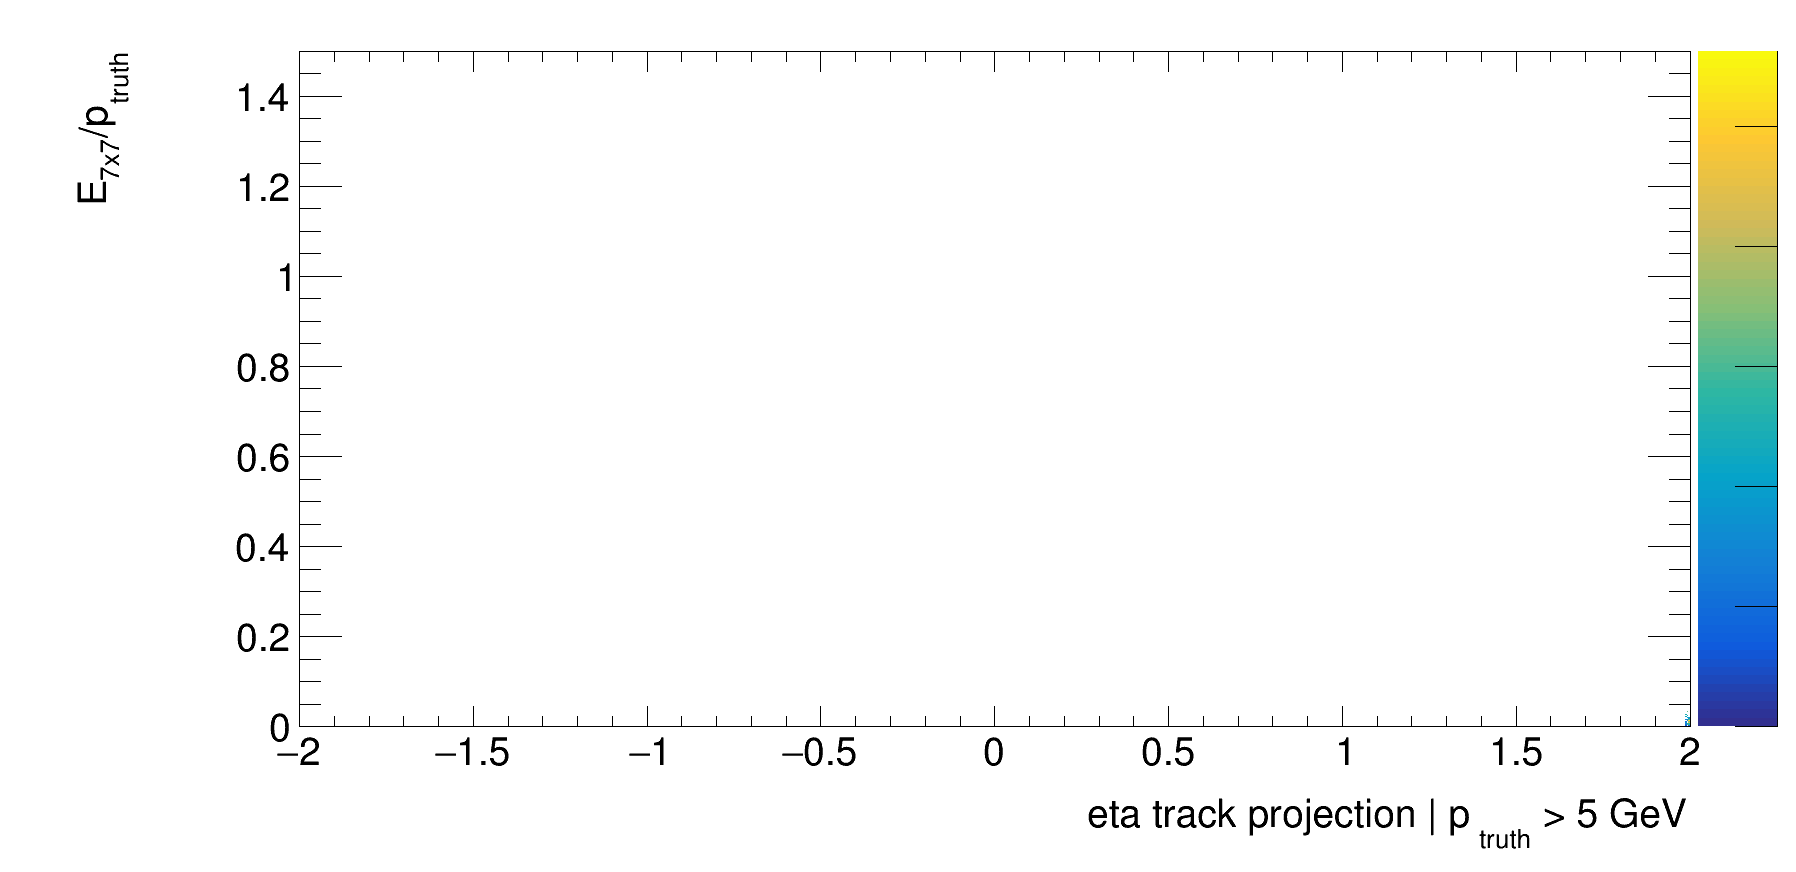

In [20]:
%%cpp

{

    
    const char *hist_name_prefix = "ShowerScan";
    auto c1 = new TCanvas(TString("ShowerScan") ,
                        TString("TowerScan"),
                        1800, 900);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hEpresponse",";eta track projection | p_{truth} > 5 GeV;E_{7x7}/p_{truth}", 1000,-2,2, 1000,0,1.5);
        T->Draw("LFHCAL_0_Tower_E7x7/m_tr_p:TMath::ATanH(LFHCAL_0_proj_z/sqrt(LFHCAL_0_proj_x**2 + LFHCAL_0_proj_y**2 + LFHCAL_0_proj_z**2))>>hEpresponse","(LFHCAL_0_Tower_E7x7/m_truthp) * (m_truthp>5)","colz");
        
    }
    c1->Draw();
}

## LFHCAL_5

Check 7x7 tower sum next to track projection vs turth or reco momentum

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


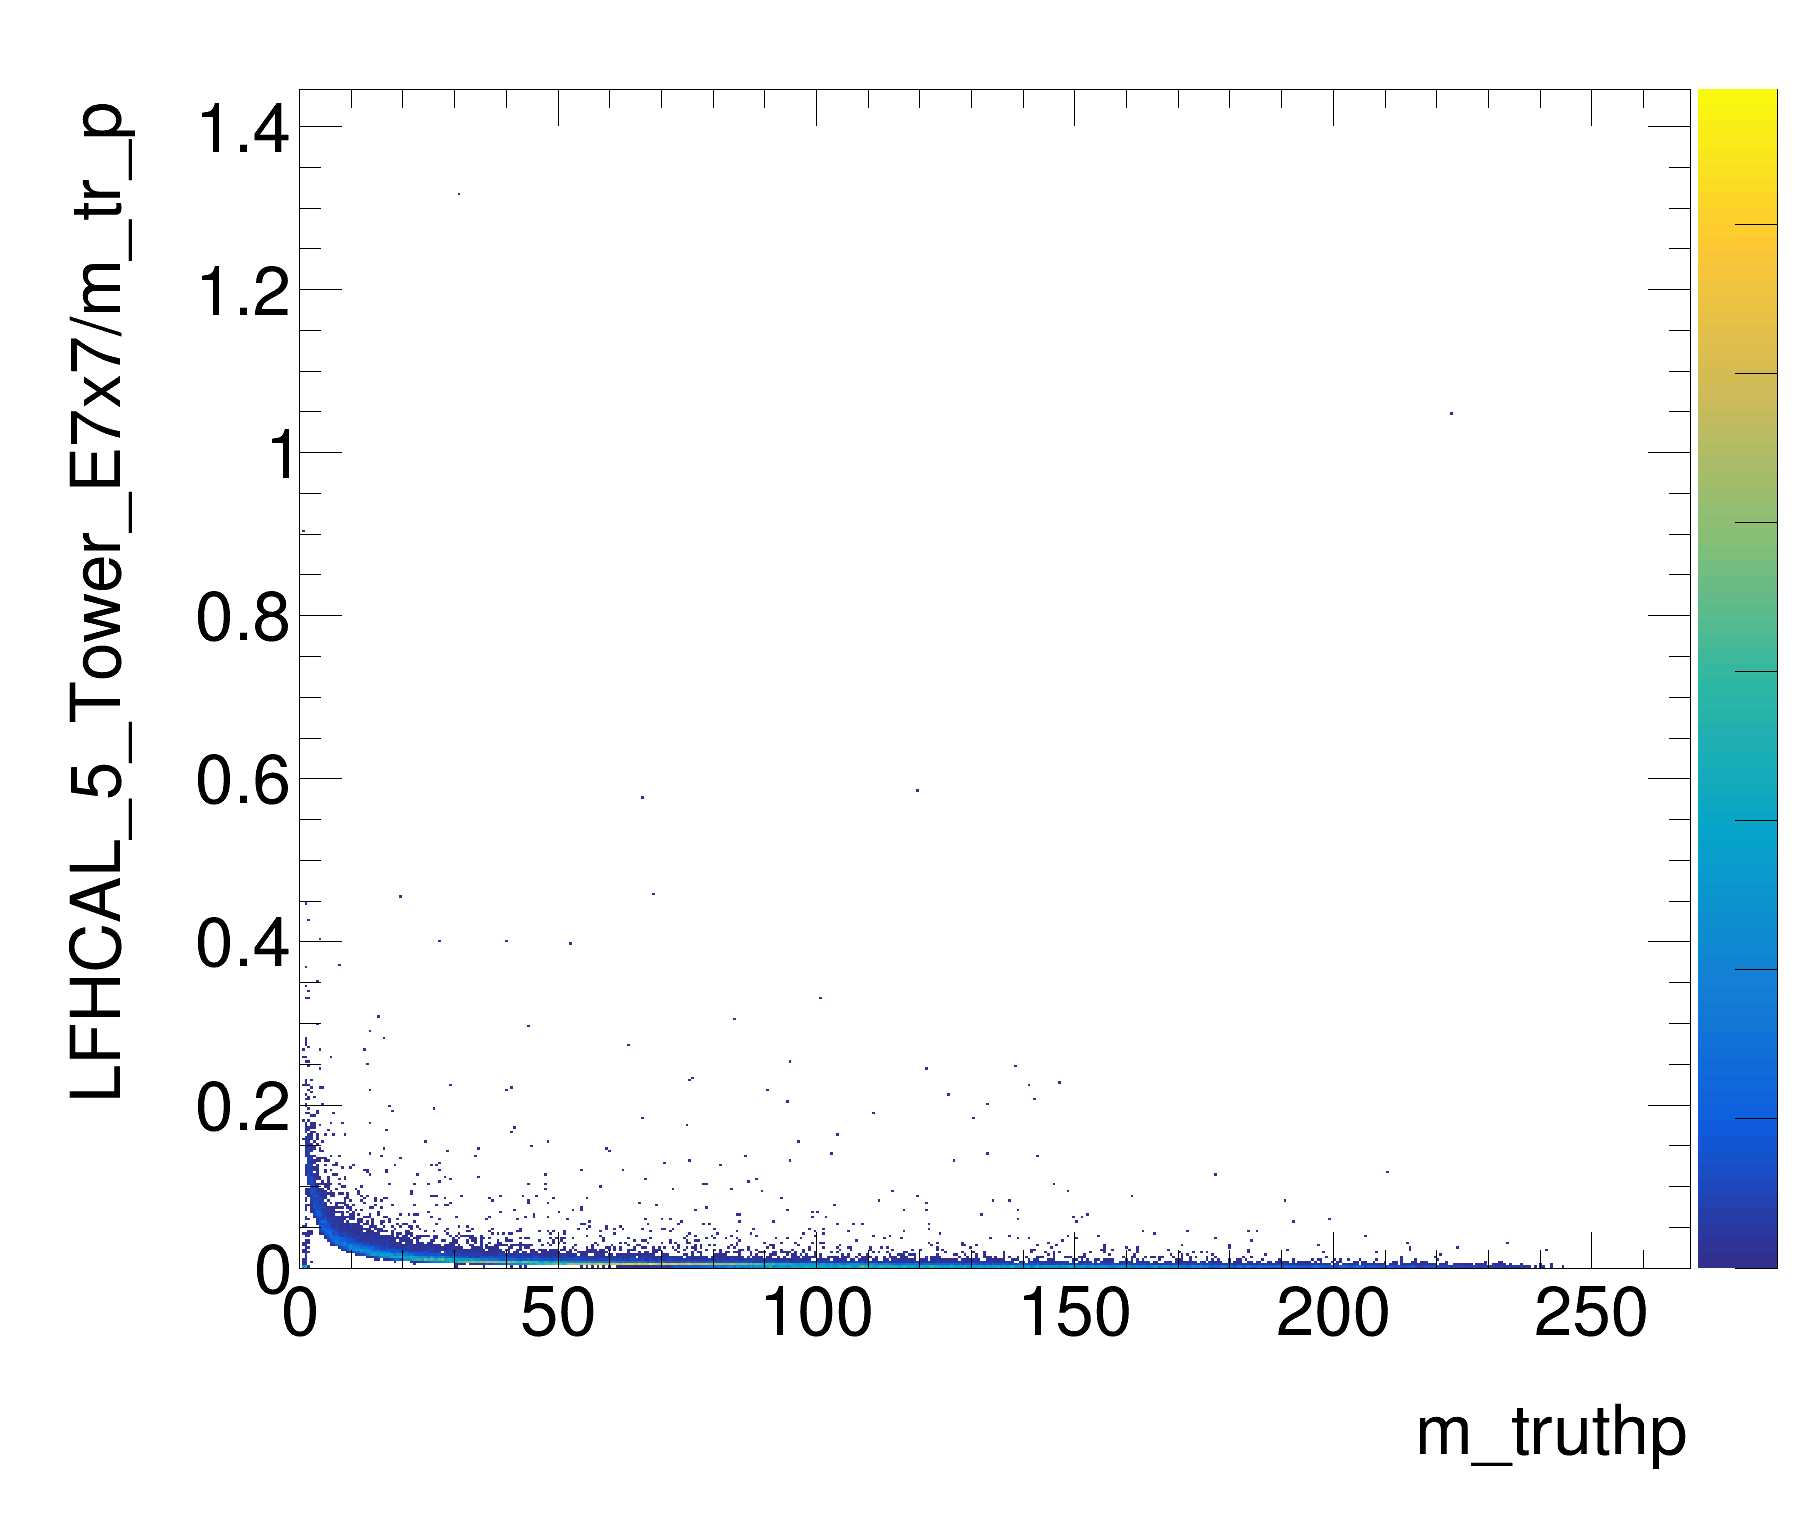

In [21]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("LFHCAL_5_Tower_E7x7/m_tr_p:m_truthp","m_tr_p>0","colz");
    }
    
    
    c1->Draw();
}

### Track based shower profile check

#### Shower shape in 7x7 tower patch grid

Check 7x7 tower patch next to the track projection with weight of the tower energy


Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan
Warning in <TFile::Append>: Replacing existing TH1: hpatch2D (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchPhi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hE7x7pTruth (Potential memory leak).


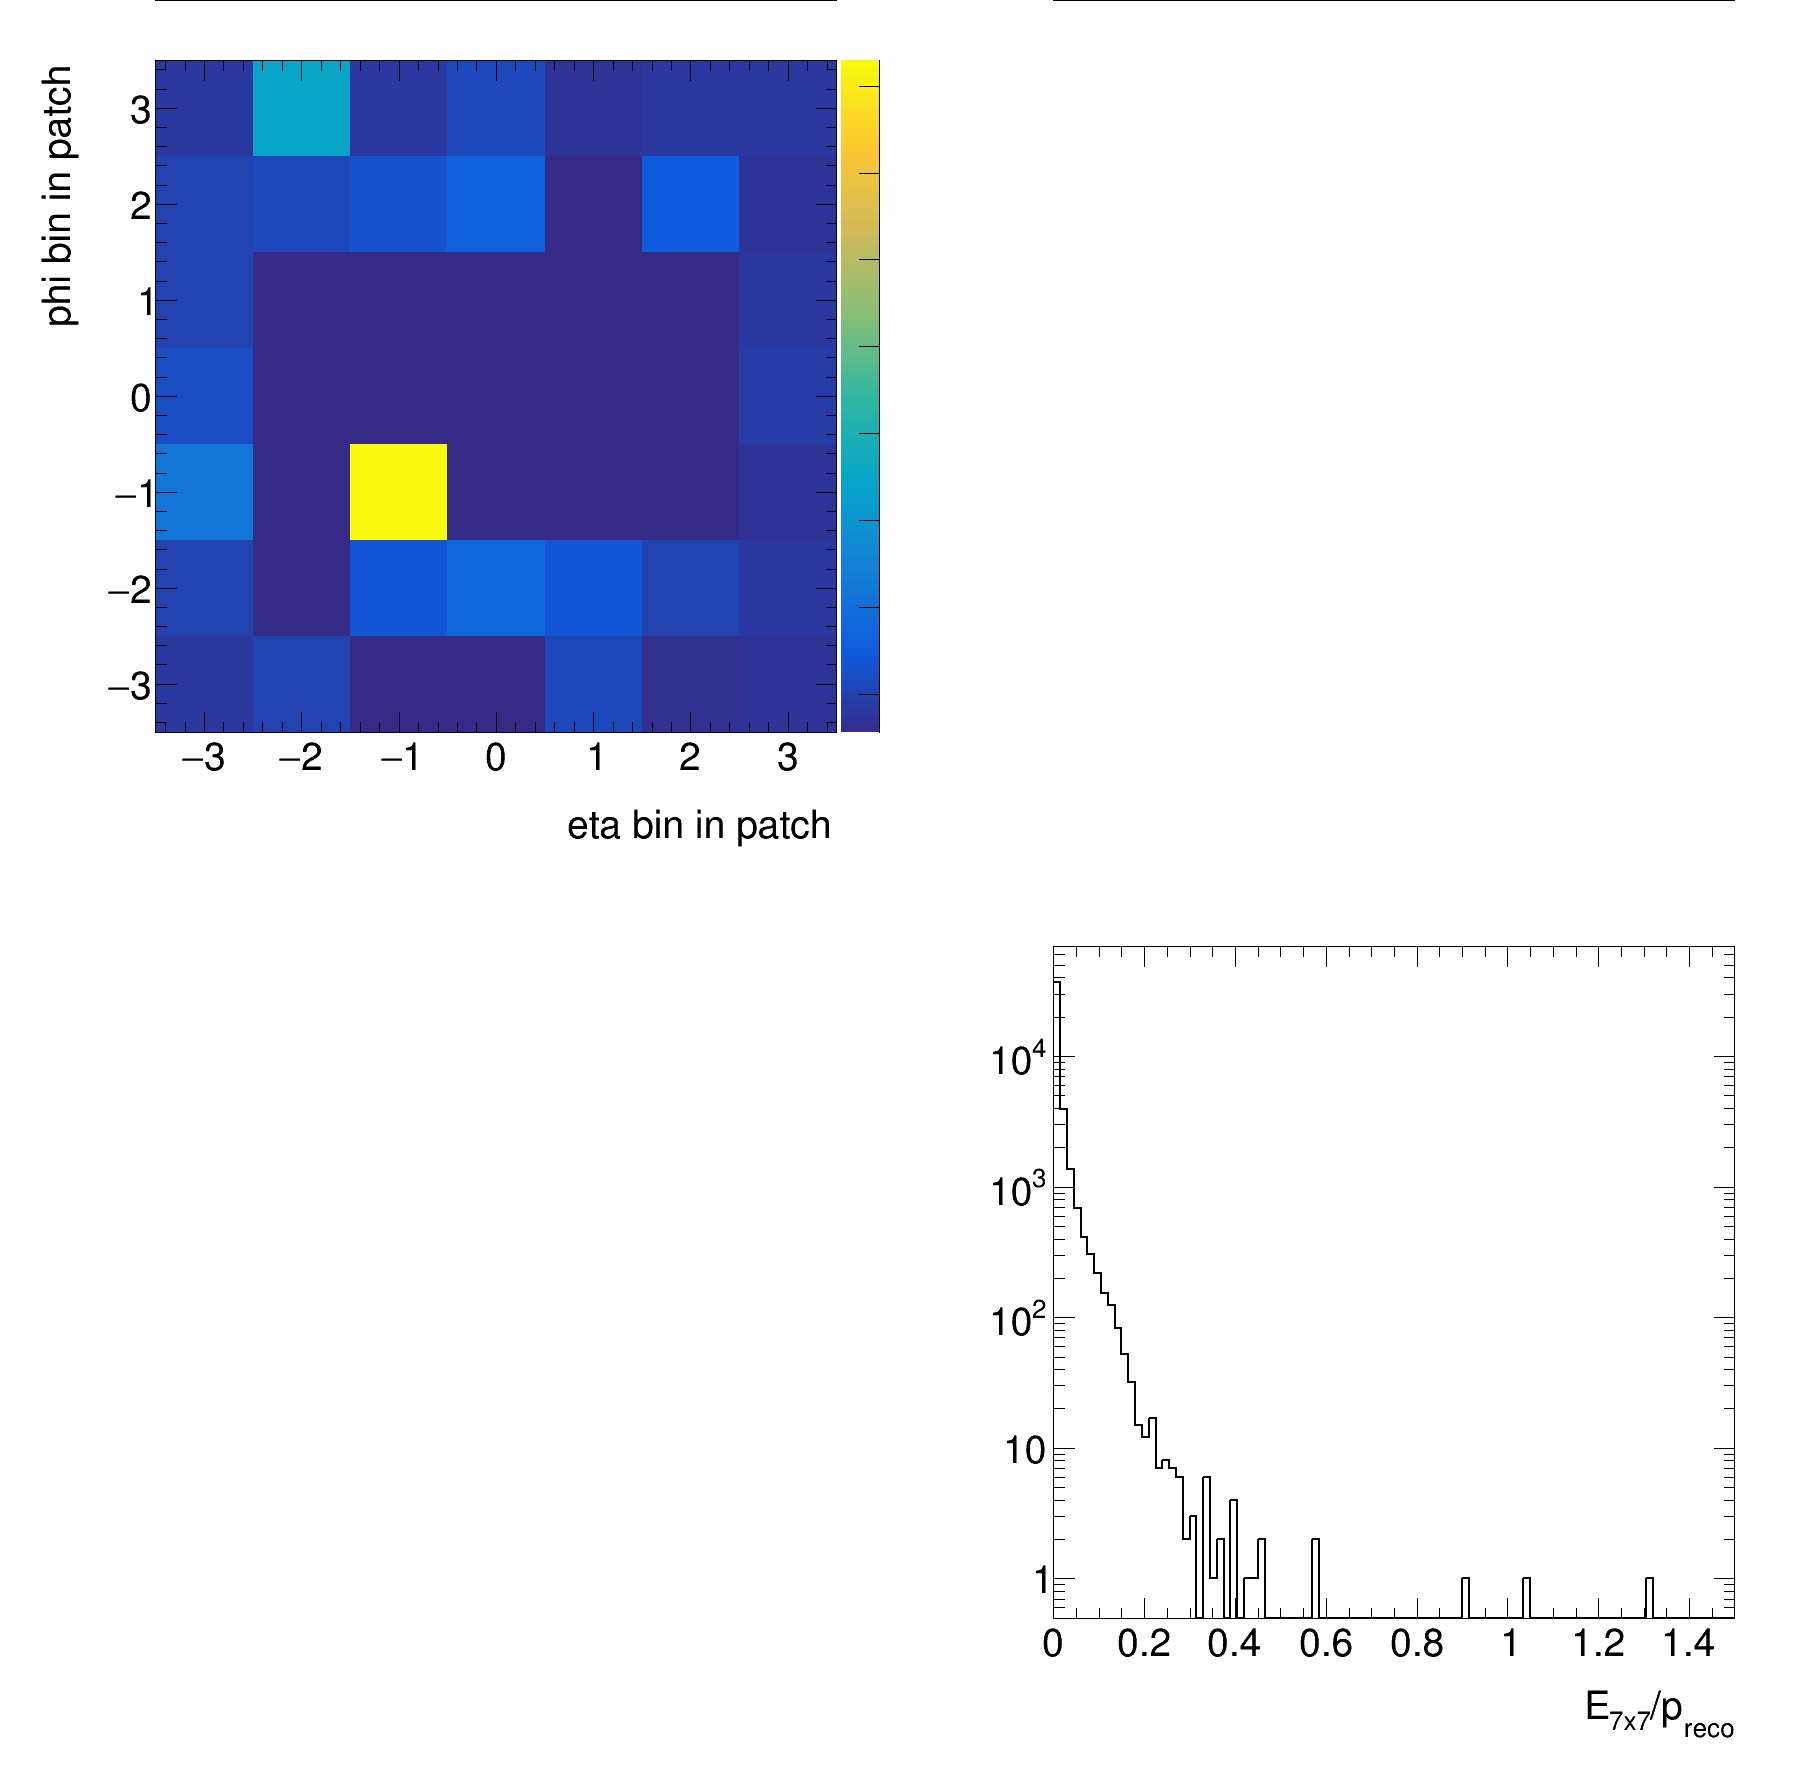

In [22]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta bin in patch;phi bin in patch",7,-3.5,3.5,7,-3.5,3.5);
        T->Draw("LFHCAL_5_Tower_iPhi_patch:LFHCAL_5_Tower_iEta_patch>>hpatch2D","LFHCAL_5_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";Phi bin in patch",7,-3.5,3.5);
        T->Draw("LFHCAL_5_Tower_iPhi_patch>>hpatchPhi","LFHCAL_5_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";Eta bin in patch",7,-3.5,3.5);
        T->Draw("LFHCAL_5_Tower_iEta_patch>>hpatchEta","LFHCAL_5_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",100,0,1.5);
        T->Draw("LFHCAL_5_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

#### shower shape in eta phi distance

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerEtaPhiScan
Warning in <TFile::Append>: Replacing existing TH1: hpatch2D (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchPhi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpatchEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hE7x7pTruth (Potential memory leak).


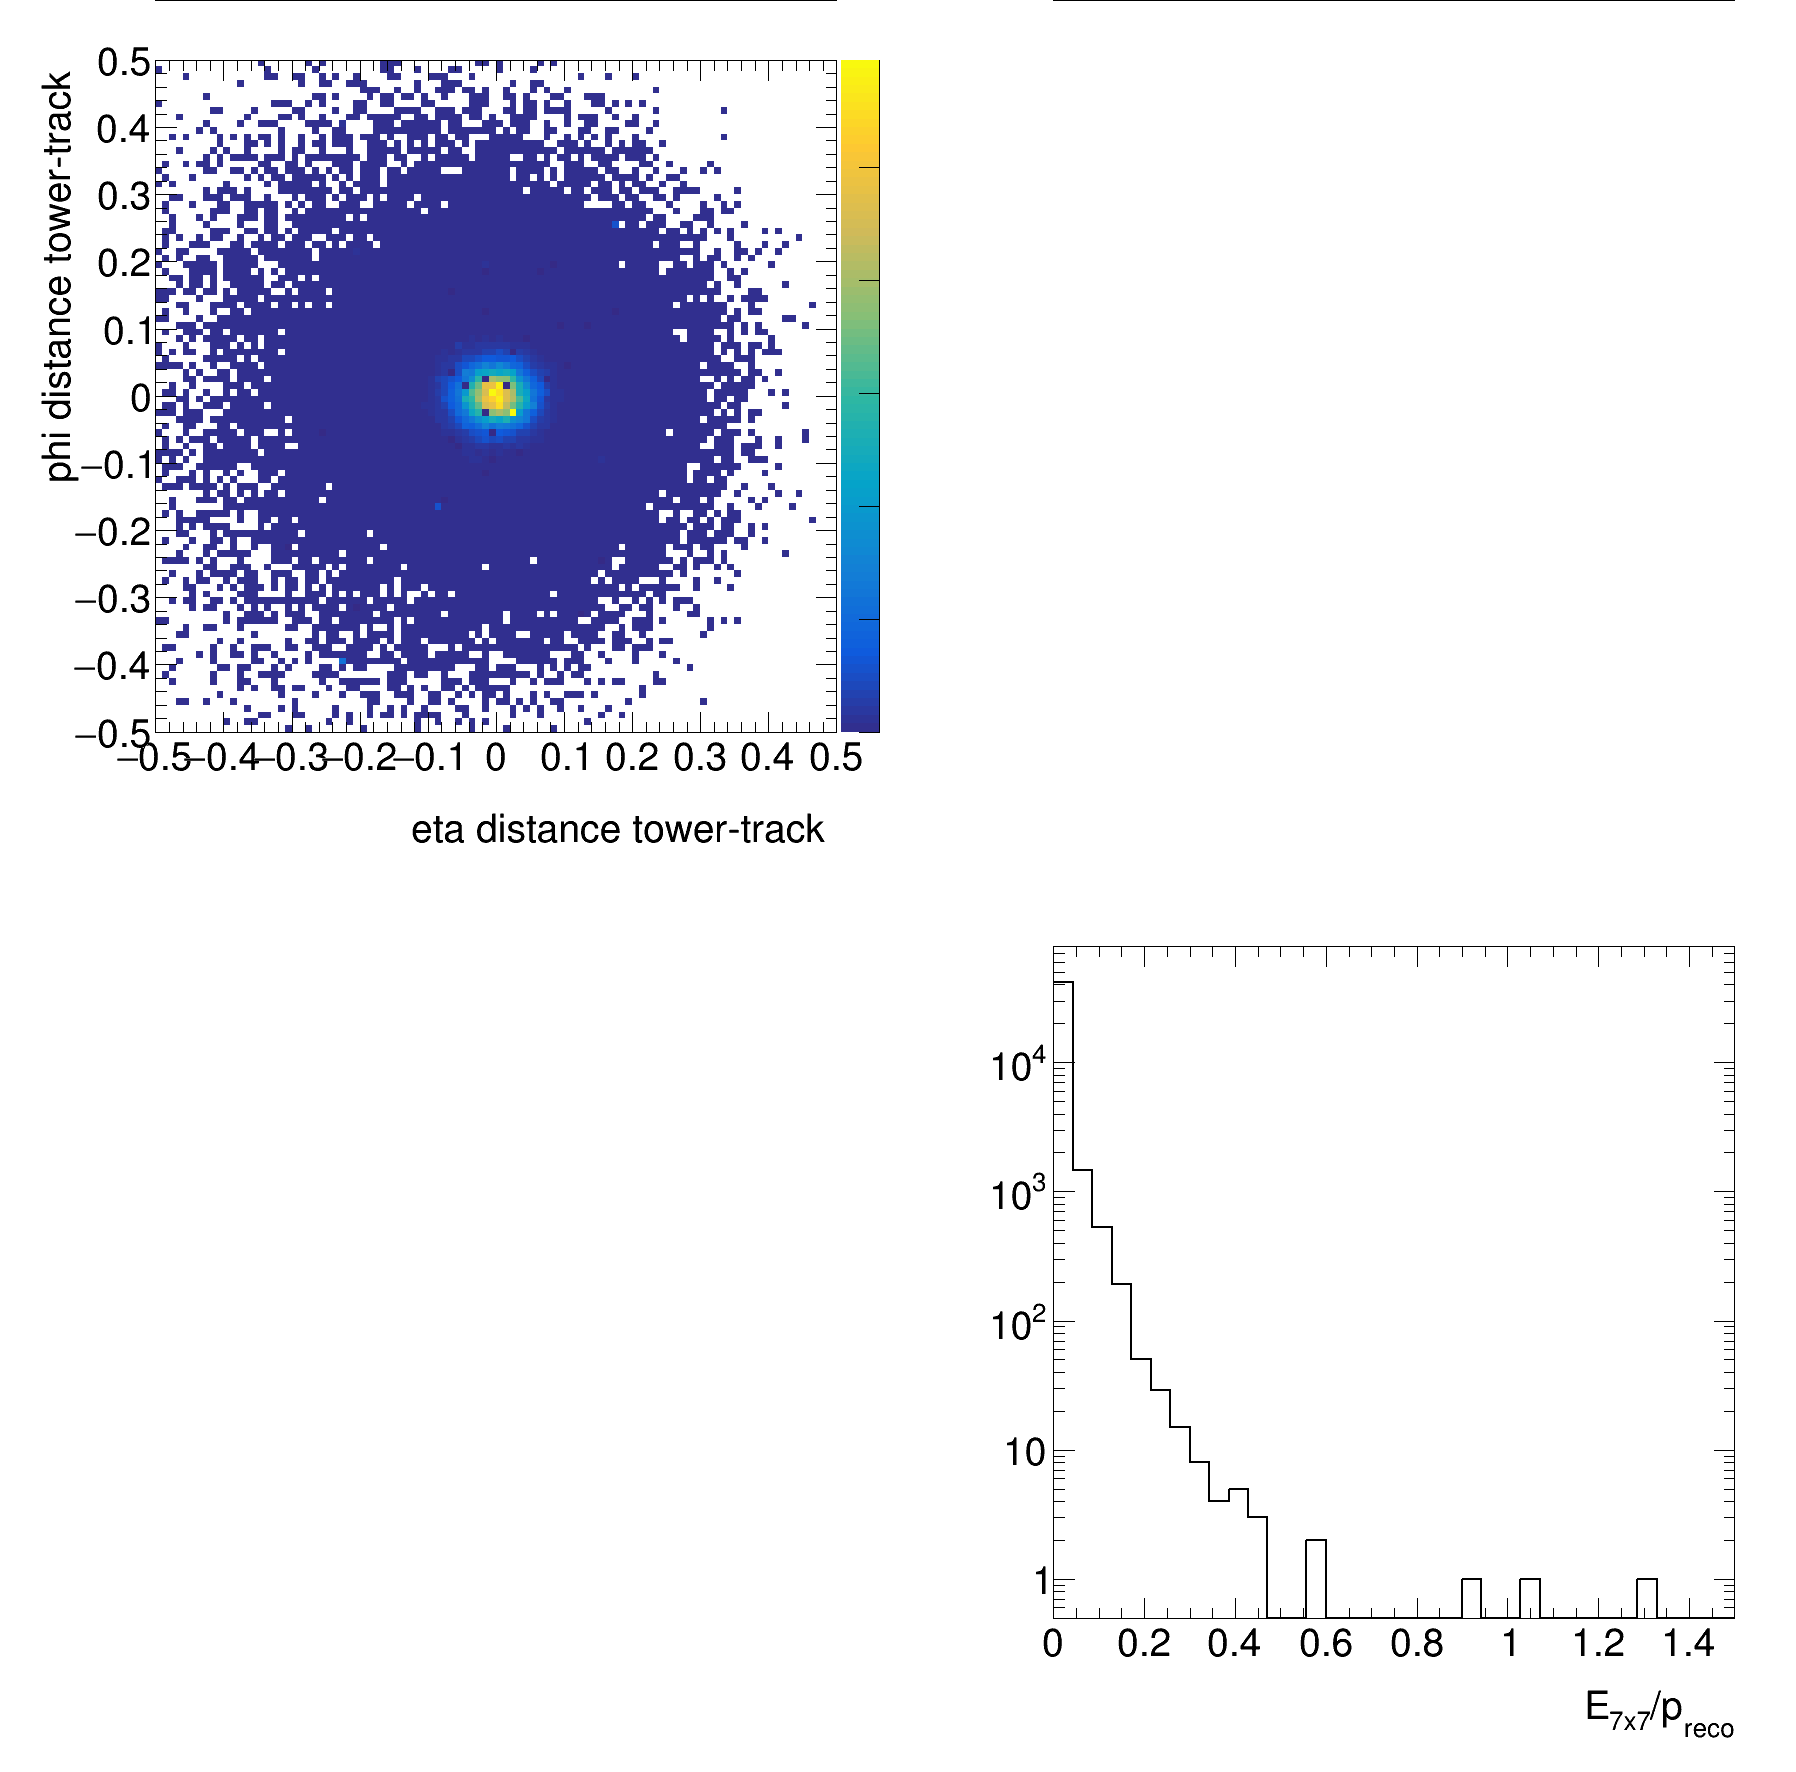

In [23]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerEtaPhiScan";
    auto c1 = new TCanvas(TString("TowerEtaPhiScan") ,
                        TString("TowerEtaPhiScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta distance tower-track;phi distance tower-track",100,-.5,.5, 100,-.5,.5);
        T->Draw("LFHCAL_5_Tower_dPhi:LFHCAL_5_Tower_dEta>>hpatch2D","LFHCAL_5_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";phi distance tower-track",100,-.5,.5);
        T->Draw("LFHCAL_5_Tower_dPhi>>hpatchPhi","LFHCAL_5_Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";eta distance tower-track",100,-.5,.5);
        T->Draw("LFHCAL_5_Tower_dEta>>hpatchEta","LFHCAL_5_Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{reco}",35,0,1.5);
        T->Draw("LFHCAL_5_Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ShowerScan
Warning in <TFile::Append>: Replacing existing TH1: hEpresponse (Potential memory leak).


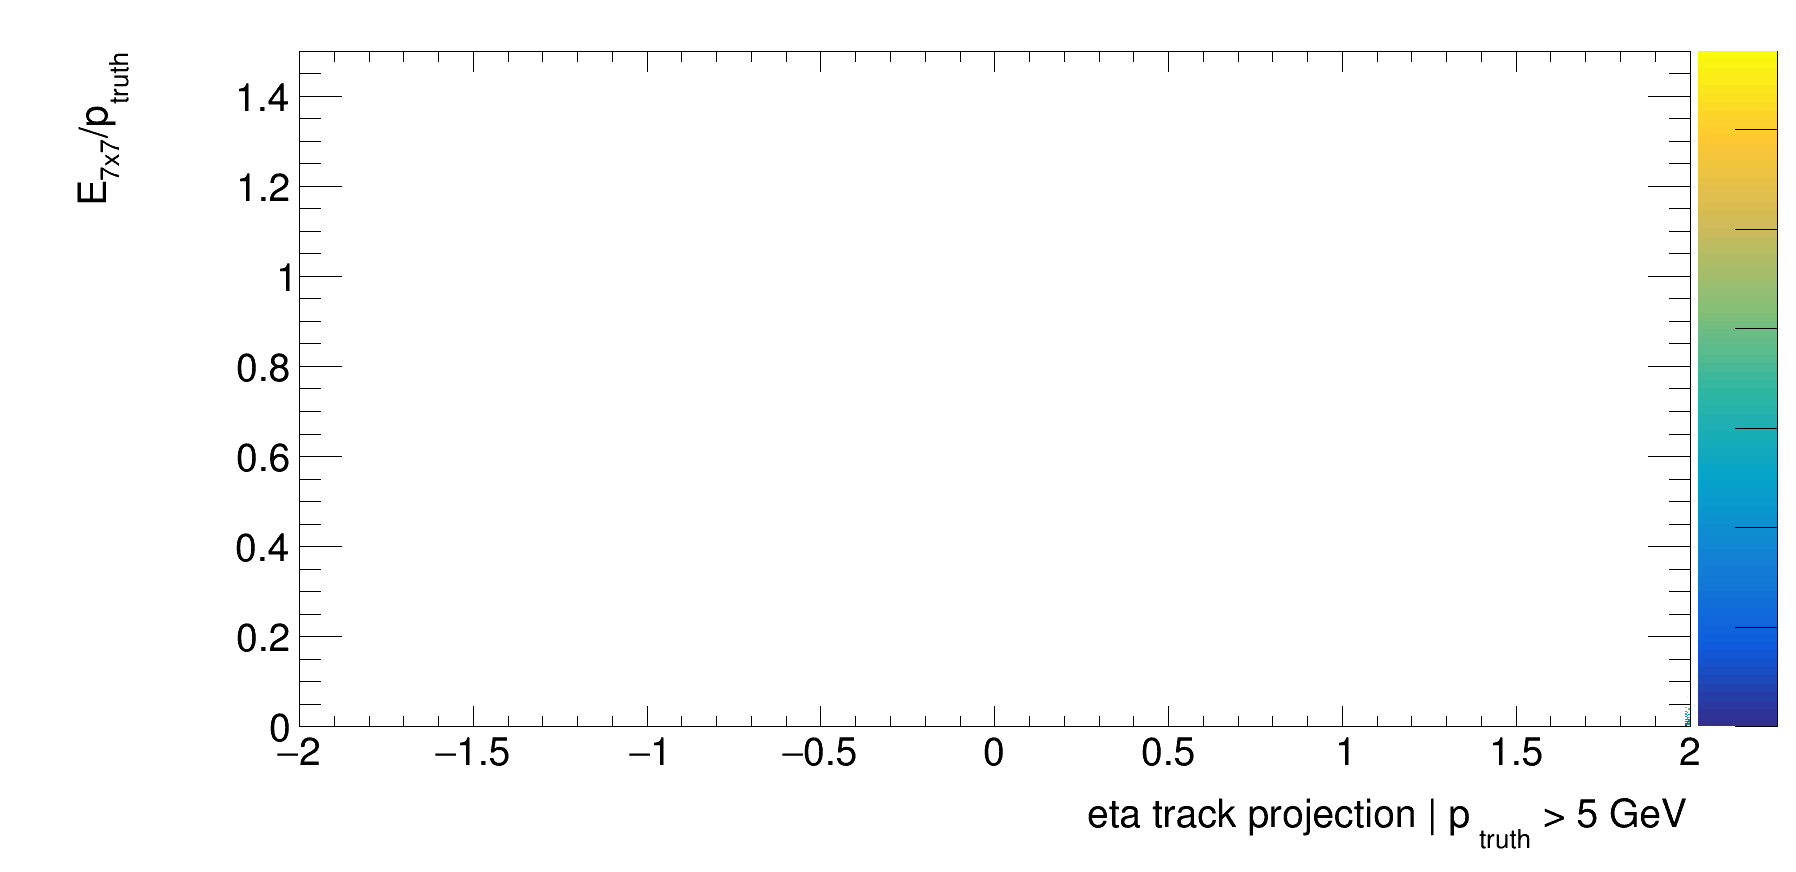

In [24]:
%%cpp

{

    
    const char *hist_name_prefix = "ShowerScan";
    auto c1 = new TCanvas(TString("ShowerScan") ,
                        TString("TowerScan"),
                        1800, 900);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hEpresponse",";eta track projection | p_{truth} > 5 GeV;E_{7x7}/p_{truth}", 1000,-2,2, 1000,0,1.5);
        T->Draw("LFHCAL_5_Tower_E7x7/m_tr_p:TMath::ATanH(LFHCAL_5_proj_z/sqrt(LFHCAL_5_proj_x**2 + LFHCAL_5_proj_y**2 + LFHCAL_5_proj_z**2))>>hEpresponse","(LFHCAL_5_Tower_E7x7/m_truthp) * (m_truthp>5)","colz");
        
    }
    c1->Draw();
}